# Defining all the constants required (copying them from Matlab and adjusting syntax)

In [1]:
from dolfin import *

#importing mshr for all mesh functions
import mshr as mshr

# Use SymPy to compute f from the manufactured solution u
import sympy as sym

#have to define where to put plots BEFORE importing matplotlib
%matplotlib notebook

#Importing matplotlib to plot the results
from matplotlib import pyplot as plt

#Importing numpy to work with arrays
import numpy as np

#Importing time to compute how long each segment takes
import time

#importing regex to change every instance of radius_tot so we change the ones in the C++ code
#at the same time too
import re

#varname gives the name of the variable as a string
from varname import varname

#Needed to use the 3D scatter
from mpl_toolkits.mplot3d import Axes3D

#Importing the decimal package to be able to specify arbitrary accuracy, needed e.g. when
#calculating the jacobian for the lensing
from decimal import *

#Increasing the width of the notebook (visual difference only)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Needed if want to use the adapt function for mesh refinement, see:
#https://fenicsproject.org/qa/6719/using-adapt-on-a-meshfunction-looking-for-a-working-example/
parameters["refinement_algorithm"] = "plaza_with_parent_facets"

c = 2.998*10**8
G = 6.674*10**(-11) 
a0 = 1.2*10**(-10) 
ms = 1.989*10**30 
mgd = 10**12*ms 
mgb = 1.1*6.6*10**10*ms
ly = 9.461*10**15 
kp = 3261.56*ly 
kpm = 20*kp 
au = 0.0000158*ly 
lst = 200*au 
lsu = 50*au 
lg = 52850*ly 
lgu = 40*10**3*ly 
lgb = 3*kp 
rs = 0.00465*au 
#Setting domain_size to the radius of the Virgo Cluster, 2.3 Mpc
domain_size = 2300*kp
#Smallest size of a galaxy in Virgo has a radius = r_Virgo/250, so that's the resolution we need
radius_tot = domain_size/250
radius_refine = radius_tot
volume_out = 4/3*pi*(radius_tot**3)
#Standard deviation for coarse mass distribution and location of peaks
stand_dev = domain_size/(10*3)
#Standard deviation for the gaussian peaks themselves
stand_dev_peak = domain_size/(250*3)
mesh_resolution = 21
#Coefficient for GEA changing the potential based on how spherically symmetric the mass distribution is
c_2 = -1.8
#Coefficient for GEA giving the magnitude of the K^3/2 term in the Lagrangian, which determines the
#interpolation function
beta = 6/sqrt(2+c_2)
#Resolution of the uniform grid onto which we interpolate our results to have nicer plots
plot_resolution = mesh_resolution
#Size of the mesh for plotting. Should be bigger than the normal one or some points might be outside its domain
mesh_plot_size = domain_size*0.8
refine_times = 6
p = 1*kp
source_number = 50
source_mass = mgb/source_number
radius_population = domain_size/2
#IMPORTANT!!! It might be that interpolating on a linear space makes all derivatives disappear:
#https://fenicsproject.org/qa/9893/simple-question-about-derivation/
#However, I should be fine cause I do the derivative, then interpolate it on a linear space and do it again
#So I never take a second derivative on the same space technically
#Interpolating all the lensing parameters onto new function spaces is expensive. Only do if needed
lensing_interpolations = False
#giving the option to use a finer, regular mesh and all functions interpolated on it for all plotting
plotting_option = False
#Deciding if we want the sources to all be in the same plane (can make it easier to get good contours, or
#for thin lens approximation for lensing)
coplanar_sources = True

In [2]:
mgb

1.4440140000000002e+41

In [3]:
#making a class for runtimes of each section to profile the program. it has a time and a name
#attribute, so when plotting we can directly use the name in e.g. a bar chart or pie chart
class run_time:
    
    #initialising class
    def __init__(self, time, name):
        self.time = time
        self.name = name

## Defining the initial mesh

In [4]:
## starting time of PDE solver
starting_time = time.time()
mesh_generation_start = time.time()

#starting an empty list to contain all of the run_time objects to plot later
section_times = []

print('Starting mesh generation...\n')
#Declaring the mesh as a sphere with an origin at (0,0,0) and radius domainsize
origin = Point(0,0,0)

#Defining the domain for the mesh using the Sphere function from mshr
domain = mshr.Sphere(origin, domain_size)

#Meshing the sphere generated with resolution 10 (cells per dimension)
mesh = mshr.generate_mesh(domain, mesh_resolution)

mesh_generation_end = time.time()
mesh_generation_time = run_time(mesh_generation_end - mesh_generation_start, 'Mesh Generation')
section_times.append(mesh_generation_time)
print('Mesh generated in {} s \n'.format(mesh_generation_time.time))

Starting mesh generation...

Mesh generated in 2.5633704662323 s 



## Defining function to mark cells within a certain radius for a given mesh

In [5]:
def inside_circle (mesh, radius):
    '''Function to mark all elements that have their center farther than a certain
    radius.'''
    
    #Defining the origin based on the geometric dimension of the mesh (plane 2 volume 3)
    origin = Point(np.zeros((mesh.geometric_dimension(),1)))
        
    #List comprehension with a single True corresponding to the cell containing the point
    is_in_list = [cell.distance(origin) < radius for cell in cells(mesh)]
    
    inside_cell_index = np.nonzero(is_in_list)
    
    #Converting list to a np array so it's faster (and has 0 and 1 so can be sorted)
    is_in_numpy = np.fromiter(is_in_list, float, mesh.num_cells())
    
    #Indices at which we have non-zero in the numpy array are the cell indices we need
    is_outside_index = np.nonzero(is_in_numpy)

    return inside_cell_index

## Trying to create mesh from scratch using the MeshEditor

## Next, using the inside_circle function to exclude cells outside a given radius

In [6]:
def circle_grid_mesh(mesh, radius, show_mesh = True):
    
    #Getting the MeshFunction and numpy array containing whether each cell satisfies the function
    inside_cell_index = inside_circle(mesh, radius)

    #Getting the vertex indices only for the cells that are inside the required radius
    inside_cells_vertices_old = mesh.cells()[inside_cell_index]

    #Number of remaining cells, given by the number of rows in the array (shape[0])
    inside_cell_number = inside_cells_vertices_old.shape[0]

    #Finding the indices of all the vertices included in the remaining cells (only need each index
    #once, hence we use unique)
    inside_vertex_old = np.unique(inside_cells_vertices_old)

    #Getting the coordinates of each vertex of cells contained in the radius
    inside_vertex_coordinates = mesh.coordinates()[inside_vertex_old]

    #Number of remaining vertices (same way as for cells)
    inside_vertex_number = inside_vertex_old.shape[0]

    #New indices for the vertices, fom 0 to #vertices
    inside_vertex_new = np.arange(inside_vertex_number)

    #Replacing the old vector indices by the new vector indices in the cell array
    #Approach from StackExchange: https://stackoverflow.com/questions/55949809/
    #efficiently-replace-elements-in-array-based-on-dictionary-numpy-python
    #Making np. zero array with as many elements as the initial # vertices
    mapping_old_new = np.zeros(inside_vertex_old.max()+1,dtype=inside_vertex_new.dtype)

    #Replacing the zero at the position of each old vertex, with the corresponding new vertex!
    mapping_old_new[inside_vertex_old] = inside_vertex_new

    #Now indexing each element of the mapping by an element of the cells_vertices array. So each
    #old vertex is replaced by a new vertex! Super efficient and fast
    inside_cells_vertices_new = mapping_old_new[inside_cells_vertices_old]
    
    #Now we have a list of cells and vertices that we want to put into the mesh
    #Declaring an empty object from the MeshEditor class
    editor = MeshEditor()

    #Declaring an empty mesh to use in the mesh editor
    test_mesh = Mesh()

    #Opening the line mesh in the mesh editor, with given topological and geometric dimensions
    editor.open(test_mesh, mesh.cell_name(), mesh.topology().dim(), mesh.geometric_dimension())

    #Initialising the mesh with the # vertices corresponding to the cells inside the radius
    editor.init_vertices(inside_vertex_number)

    #Initialising an amount of cells equal to those inside the given radius
    editor.init_cells(inside_cell_number)

    #Adding all the vertices from cells inside radius
    for vertex_index, vertex in enumerate(inside_vertex_coordinates):
        editor.add_vertex(vertex_index, vertex)

    #Giving list of cells with the new indexing
    for cell_index, cell_vertices in enumerate(inside_cells_vertices_new):
        editor.add_cell(cell_index, cell_vertices)

    #Closing the mesh editor
    editor.close()
    
    #Plotting mesh if necessary
    if show_mesh:

        plt.figure()
        plot(test_mesh, color = 'w')
        
    #Returning the mesh object
    return test_mesh

In [7]:
def make_cube_mesh(side_length, resolution):
    
    #Defining extremes of main diagonal to obtain side_length*3 cube
    box_edge_low = Point(-side_length*np.array([1,1,1]))
    box_edge_high = Point(side_length*np.array([1,1,1]))
    
    #Using dolfin builtin mesh, defining edges and resolution for all 3 axes
    cubic_mesh = BoxMesh(box_edge_low, box_edge_high, resolution, resolution, resolution)
    
    #Object returned by BoxMesh is not a dolfin mesh, so we define it as such to be able to use it
    cubic_mesh = Mesh(cubic_mesh)
    
    return cubic_mesh

<IPython.core.display.Javascript object>


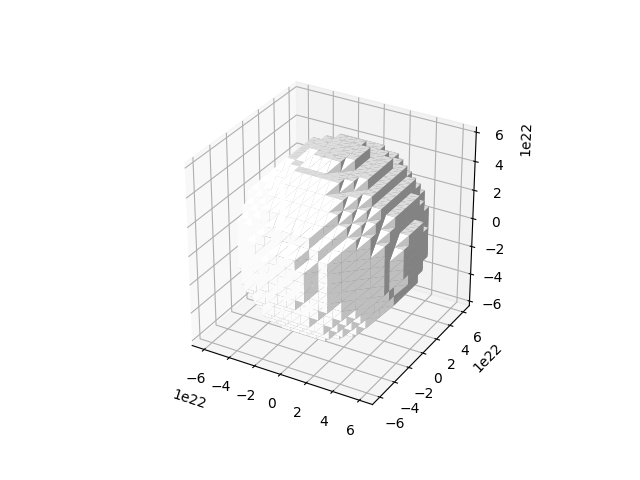

In [8]:
#Making a regular fine mesh(4 times as fine as initial unrefined mesh) to interpolate our functions over
cubic_mesh = make_cube_mesh(2*domain_size, plot_resolution*2)

#Getting a spherical mesh from the cube generated above, Making mesh slightly larger so we don't miss points 
#on the surface that are absent due to the new mesh having a smooth boundary
mesh_for_plots = circle_grid_mesh(cubic_mesh, mesh_plot_size, show_mesh=True)

#Creating a scalar function space on the large mesh, so we can interpolate functions on it and plot them
# V_plot = FunctionSpace(mesh_for_plots, 'CG', 1)

In [9]:
# mesh = mesh_from_cube
# mesh_from_cube

## Defining coordinates for some test mass distributions

In [10]:
#For all the points to be within a given radius, each coordinate must be smaller than
#radius_population/sqrt(3)
random_max_distance = radius_population/sqrt(3)

#Setting a given seed so we can always have the same random numbers for now
np.random.seed(1)

#We want a mean of 0 so center of mass is in center, and the same standard deviation as the gaussian
#pulse. This means we sample from the same distribution as the smooth one, and have the same mean.
#This is exactly what we want to compare coarse and smooth distributions
mu, sigma = 0, stand_dev
random_coordinates_x = np.random.normal(mu, sigma, source_number)
random_coordinates_y = np.random.normal(mu, sigma, source_number)
random_coordinates_z = np.random.normal(mu, sigma, source_number)

#Overall array containing all coordinates
random_coordinates = np.array((random_coordinates_x, random_coordinates_y, random_coordinates_z))
random_coordinates = np.transpose(random_coordinates)

#Defining a source_number*3 array of random numbers between 0 and 1 and multiplying by the
#radius just defined so all points are inside a sphere of radius_tot. Subtracting 0.5 so
#we're sampling equally from the positive and negative instead of from 0 to 1
# random_coordinates = random_max_distance * (np.random.rand(source_number, 3)-0.5)

# Uncomment for test case with two equal masses on the xy plane at a given distance
# their_distance = 3

# # random_coordinates[0][0] = -domain_size/their_distance
# random_coordinates[0][0] = 0
# random_coordinates[0][1] = 0
# random_coordinates[0][2] = 0

# random_coordinates[1][0] = domain_size/their_distance
# random_coordinates[1][1] = 0
# random_coordinates[1][2] = 0

#If we want all source to be in the same plane, we set the z axis to be 0 for all of them
if coplanar_sources == True:
    
    random_coordinates[:,2] = np.zeros((source_number, 1)).ravel()

# #Getting x,y,z coordinates for the center of each source
# random_coordinates_x = random_coordinates[:,0]
# random_coordinates_y = random_coordinates[:,1]
# random_coordinates_z = random_coordinates[:,2]

#Obtaining the center of each source as a list of points
source_centers = [Point(coordinates) for coordinates in random_coordinates]

# Overriding definition with known point for testing of the mesh refinement
# test_coordinates  = 5*kp*np.zeros((3,1))
# source_centers = Point(test_coordinates)

# random_coordinates
print(f'Mean in x: {abs(mu - np.mean(random_coordinates_x))/domain_size}\n') 
print(f'Mean in y: {abs(mu - np.mean(random_coordinates_y))/domain_size}\n') 
print(f'Mean in z: {abs(mu - np.mean(random_coordinates_z))/domain_size}\n') 

Mean in x: 0.0008504949335883441

Mean in y: 0.004889351738634923

Mean in z: 0.002821964268660257



In [11]:
np.zeros((source_number, 1)).ravel().shape


(50,)

In [12]:
random_coordinates.shape

(50, 3)

## Finding the center of mass for the mass distribution to correctly calculate BCs and initial guesses 

In [13]:
#COMMENTED OUT MOMENTARILY TO TEST HAVING SOURCE IN PLANE!
#NEED TO TEST IF THIS WORKS CORRECTLY WITH RANDOM POINTS. PRROBLEM BEOFR EWAS WITH MESH
#REFINEMENT, WASNT READING THE OOINT TO REFINE CORRECTLY!

#For the current case in which all sources have the same mass, we simply divide by #sources
center_of_mass_x = random_coordinates_x.sum()/source_number
center_of_mass_y = random_coordinates_y.sum()/source_number
center_of_mass_z = random_coordinates_z.sum()/source_number

#Overall center of mass
center_of_mass = [center_of_mass_x, center_of_mass_y, center_of_mass_z]

# center_of_mass = test_coordinates
# center_of_mass_x = center_of_mass[0]
# center_of_mass_y = center_of_mass[1]
# center_of_mass_z = center_of_mass[2]

# # #Overwriting center of mass to check if the BC works correctly
# # center_of_mass = [0,0,0]
# source_centers[0]/kp

center_of_mass

[-6.0361772143810814e+19, 3.4700963394718473e+20, 2.0028192697652609e+20]

## Rearranging cells according to distance from the center so we can then loop over this rearranged version and break from the loop once we find all sources

In [14]:
# starting = time.time()
# #Obtaining an iterable for the value of the midpoint of each cell
# cell_midpoints = [cell.midpoint().norm() for cell in cells(mesh)]

# #Constructing a numpy array out of the iterable, much faster instead of a list
# cell_midpoints = np.fromiter(cell_midpoints, float, mesh.num_cells())

# #Index to order all cells according to the distance of their center to the origin
# cell_sorting_index = cell_midpoints.argsort()

# #Sorting the midpoints by their radius
# cell_midpoints_sorted = cell_midpoints[cell_sorting_index]


# # mesh.cells()[0,:]
# # mesh.cells()[cell_sorting_index]
# # # mesh.cells() = mesh.cells()[cell_sorting_index]
# cells(mesh)
# # print(f'Time for midpoint: {time.time() - starting}')


#Creating a MeshFunction to indicate which cells to loop over (e.g. only the ones close to
#the point contained in the cell we will refine)
# contain_time_loop = time.time()

# contain_list.set_all(False)

# for cell in cells(mesh):
#     if cell.contains(origin):
        
#         contain_list[cell] = True

# print(f'Time for loop: {time.time()-contain_time_loop}')


In [15]:
# mesh = mshr.generate_mesh(domain, mesh_resolution)

In [16]:
# contain_time_list = time.time()

# index_1 = 400
# index_2 = index_1+10

# # print(f'Before. Total:{mesh.num_cells()}\n. Cells:\n {mesh.cells()[index_1:index_2]}\n')

# #Declaring Boolean Mesh Function to individuate cell containing point
# contain_function = MeshFunction("bool", mesh, 3)

# #Setting function to False everywhere
# contain_function.set_all(False)

# #setting empty array to append indices of cells containing point
# cell_index = np.zeros((source_number, 1))

# print(f'cells = {mesh.num_cells()}')

# for i, source in enumerate(source_centers):

#     #List comprehension with a single True corresponding to the cell containing the point
#     contain_list = [cell.contains(source) for cell in cells(mesh)]

#     #Converting list to a np array so it's faster (and has 0 and 1 so can be sorted)
#     contain_numpy = np.fromiter(contain_list, float, mesh.num_cells())
    
# #     print(f'contain_numpy has {contain_numpy.sum()} ones\n')
    
#     #Getting index of non-zero elements of contain_numpy, only 1 for the cell that's true.
#     #Then setting the MeshFunction True at those cells
#     cell_index[i] = np.nonzero(contain_numpy)[0]
    
# print(f'the cell index containing the point is \n {cell_index[0:10]}\n...')

# for cell_containing in cell_index:
    
#     contain_function[cell_containing] = True

# test_mesh = refine(mesh, contain_function)    
 
# print(f'cells = {test_mesh.num_cells()}')
    
# print(f'Time for list: {time.time() - contain_time_list}')


# # print(f'Before. Total:{mesh.num_cells()}\n. Cells:\n {mesh.cells()[index_1:index_2]}\n')

# contain_mesh_function = [contain_function[i] for i in range(test_mesh.num_cells())]

# contain_mesh_function_numpy = np.fromiter(contain_mesh_function, float, test_mesh.num_cells())

# contain_mesh_function_numpy.sum()

In [17]:
def modified_refinement (mesh, location, radius, how_many, technique = 'inside'):
    '''Function to refine mesh locally, based on the distance from a given point
    '''
    
    #Starting # cells before we refine, to compute growth factor
    starting_cells = mesh.num_cells()
    
    if how_many > 0:
    
        for i in range(how_many):
        
            #Declaring Boolean Mesh Function to individuate cell containing point
            contain_function = MeshFunction("bool", mesh, 3)

            #Setting function to False everywhere
            contain_function.set_all(False)

            #setting empty array to contain indices of cells containing point
            cell_index = np.zeros((source_number, 1))
        
            for j, source in enumerate(location): 
                
                print(f'Source {j+1} of {source_number}', end="\r", flush=True)
                
                #IMPORTANT: Need to declare (and set to False) the cell_to_refine function
                #for each source, as the mesh is different after each iteration!
                #Initial mesh cell count
                initial_cells = mesh.num_cells()
                
                #List comprehension with a single True corresponding to the cell containing the point
                contain_list = [cell.contains(source) for cell in cells(mesh)]

                #Converting list to a np array so it's faster (and has 0 and 1 so can be sorted)
                contain_numpy = np.fromiter(contain_list, float, mesh.num_cells())
                
#                 print(f'contain_numpy has {contain_numpy.sum()} ones\n')

                #Getting index of non-zero elements of contain_numpy, only 1 for the cell that's true.
                #Then setting the MeshFunction True at those cells
                cell_index[j] = np.nonzero(contain_numpy)[0]

            for cell_containing in cell_index:

                contain_function[cell_containing] = True

            mesh = refine(mesh, contain_function)    
#             print(f'cell_containing is {cell_containing}')  
                
#             #Refining the mesh only where the markers are True, so inside the desired radius 
#             mesh = refine(mesh, contain_function)

            final_cells = mesh.num_cells()

            partial_growth_factor = final_cells/initial_cells
            
            print(('Iteration {} of {}: The Cell number went from {} to {}, up by a factor {}\n'
                  .format(i+1, how_many, initial_cells, final_cells, partial_growth_factor)))
    
        #ratio between # cells at beginning and end of refinement
        total_growth_factor = final_cells/starting_cells

        print('Cell number went up by a factor {}\n'.format(total_growth_factor))
    
    #returning the refined mesh
    return mesh

In [18]:
#NOT WORKING AND CANT SEEM TO SEE WHY. MORE_MODIFIED PROBABLY FASTER ANYWAY

def adapt_modified_refinement (mesh, location, radius, how_many, technique = 'inside'):
    '''Function to refine mesh locally, based on the distance from a given point
    '''
    
    #Starting # cells before we refine, to compute growth factor
    starting_cells = mesh.num_cells()
    
    if how_many > 0:
    
        #Declaring Boolean Mesh Function to individuate cell containing point
        contain_function = MeshFunction('size_t', mesh, 3)

        #Setting function to False everywhere
        contain_function.set_all(False)

        
        for i in range(how_many):
        
            #setting empty array to contain indices of cells containing point
            cell_index = np.zeros((source_number, 1))
            
            #If not the first iteration, no need to re-define the function
            if i>0:
            
                mesh = new_mesh
            else:
                
                for j, source in enumerate(location): 

                    print(f'Source {j+1} of {source_number}', end="\r", flush=True)

                    #IMPORTANT: Need to declare (and set to False) the cell_to_refine function
                    #for each source, as the mesh is different after each iteration!
                    #Initial mesh cell count
                    initial_cells = mesh.num_cells()

                    #List comprehension with a single True corresponding to the cell containing the point
                    contain_list = [cell.contains(source) for cell in cells(mesh)]

                    #Converting list to a np array so it's faster (and has 0 and 1 so can be sorted)
                    contain_numpy = np.fromiter(contain_list, float, mesh.num_cells())

    #                 print(f'contain_numpy has {contain_numpy.sum()} ones\n')

                    #Getting index of non-zero elements of contain_numpy, only 1 for the cell that's true.
                    #Then setting the MeshFunction True at those cells
                    cell_index[j] = np.nonzero(contain_numpy)[0]

                for cell_containing in cell_index:

                    contain_function[cell_containing] = True
            
            if i==0:
            
                mesh_new = adapt(contain_function, mesh)    
#             print(f'cell_containing is {cell_containing}')  
            
            else:
            
                mesh_new  = adapt(new_contain_function, mesh)   
        
#             #Refining the mesh only where the markers are True, so inside the desired radius 
#             mesh = refine(mesh, contain_function)
            
            new_contain_function = adapt(mesh_new, contain_function)
        
            final_cells = mesh.num_cells()

            partial_growth_factor = final_cells/initial_cells
            
            print(('Iteration {} of {}: The Cell number went from {} to {}, up by a factor {}\n'
                  .format(i+1, how_many, initial_cells, final_cells, partial_growth_factor)))
    
        #ratio between # cells at beginning and end of refinement
        total_growth_factor = final_cells/starting_cells

        print('Cell number went up by a factor {}\n'.format(total_growth_factor))
    
    #returning the refined mesh
    return mesh

In [19]:
def more_modified_refinement (mesh, location, how_many):
    '''Function to refine mesh locally, only refining cells containing one of the points described by the
    list of Dolfin Points location,a Point for each source. 
    '''
    
    #Starting # cells before we refine, to compute growth factor
    starting_cells = mesh.num_cells()
    
    #How_many gives the amount of time the mesh should be refined
    if how_many > 0:
    
        for i in range(how_many):
        
            #Declaring Boolean Mesh Function to individuate cell containing point
            contain_function = MeshFunction("bool", mesh, 3)

            #Setting function to False everywhere
            contain_function.set_all(False)
            
            #Initial number of cells before refinement
            initial_cells = mesh.num_cells()
                
            #List comprehension containing the cell IDs for the cells containing a source
            intersect_list = [intersect(mesh, source).intersected_cells() for source in location]
            
            #Setting the cell function contain_function to true for each cell containing a source
            for cell_index in intersect_list:
                contain_function[cell_index[0]] = True
            
            #Refining the mesh only for cells that contain a source
            mesh = refine(mesh, contain_function)    
            
            #Final # cells after refinement
            final_cells = mesh.num_cells()
            
            partial_growth_factor = final_cells/initial_cells
            
            print(('Iteration {} of {}: The Cell number went from {} to {}, up by a factor {}\n'
                  .format(i+1, how_many, initial_cells, final_cells, partial_growth_factor)))
    
        #ratio between # cells at beginning and end of refinement
        total_growth_factor = final_cells/starting_cells

        print('Cell number went up by a factor {}\n'.format(total_growth_factor))
    
    #returning the refined mesh
    return mesh

# Using local mesh refinement after implementing a mesh function to mark individual cells to be refined based on some condition (page 187 of book)

In [20]:
def local_refinement (mesh, location, radius, how_many, technique = 'inside'):
    '''Function to refine mesh locally, based on the distance from a given point
    '''
    
    #Starting # cells before we refine, to compute growth factor
    starting_cells = mesh.num_cells()
    
    if how_many > 0:
    
        for i in range(how_many):
        
            for j, source in enumerate(location): 
                
                print(f'Source {j+1} of {source_number}', end="\r", flush=True)
                
                #IMPORTANT: Need to delcare (and set to False) the cell_to_refine function
                #for each source, as the mesh is different after each iteration!
                #Initial mesh cell count
                initial_cells = mesh.num_cells()

                #We want to refine based on cell location, so we want to mark cells within a given radius
                #We create a MeshFunction containing a bool for each cell (3 stands for the topological
                #dimension, which is vertex->1, face->2, cell->3), on the given mesh
                cell_to_refine = MeshFunction("bool", mesh, 3)

                #Initialising all marker to false
                cell_to_refine.set_all(False)

                #cells(mesh_trial) is an iterator, so we can loop over it directly, without needing to know
                #anything about the cells
                for k, cell in enumerate(cells(mesh)):
                    
                    if (k+1)%1000 == 0:
                        print(f'Cells done: {int(k+1)} out of {mesh.num_cells()}', end="\r", flush=True)
                    
                    #With the close technique, we refine all cells with centers within a given radius
                    if str(technique) == 'close':

                        #looking at the center of the cell
                        p = cell.midpoint()

                        #if the cell is within the required radius, we set the corresponding marker to True
                        if p.distance(source) < radius:

                            cell_to_refine[cell] = True

                    elif technique == 'inside': 

                        if cell.contains(source):

                            cell_to_refine[cell] = True

                #Refining the mesh only where the markers are True, so inside the desired radius 
                mesh = refine(mesh, cell_to_refine)

                final_cells = mesh.num_cells()

                partial_growth_factor = final_cells/initial_cells
            
            print(('Iteration {} of {}: The Cell number went from {} to {}, up by a factor {}\n'
                  .format(i+1, how_many, initial_cells, final_cells, partial_growth_factor)))
    
        #ratio between # cells at beginning and end of refinement
        total_growth_factor = final_cells/starting_cells

        print('Cell number went up by a factor {}\n'.format(total_growth_factor))
    
    #returning the refined mesh
    return mesh

In [21]:
# mesh = mshr.generate_mesh(domain, mesh_resolution)

In [22]:
# print('Starting mesh refinement...\n')
# mesh_refine_start = time.time()
# new_mesh = local_refinement(mesh, source_centers, radius_refine, refine_times, technique = 'inside')
# mesh_refine_end = time.time()
# mesh_refine_time = run_time(mesh_refine_end - mesh_refine_start, 'Mesh Refinement')
# section_times.append(mesh_refine_time)
# print('Mesh refined in {} s \n'.format(mesh_refine_time.time))

In [23]:
# mesh = mshr.generate_mesh(domain, mesh_resolution)

In [24]:
print('Starting mesh refinement...\n')
mesh_refine_start = time.time()
new_mesh = more_modified_refinement(mesh, source_centers, refine_times)
mesh_refine_end = time.time()
mesh_refine_time = run_time(mesh_refine_end - mesh_refine_start, 'Mesh Refinement')
section_times.append(mesh_refine_time)
print('Mesh refined in {} s \n'.format(mesh_refine_time.time))

Starting mesh refinement...

Iteration 1 of 6: The Cell number went from 21190 to 22280, up by a factor 1.0514393581878245

Iteration 2 of 6: The Cell number went from 22280 to 24769, up by a factor 1.1117145421903052

Iteration 3 of 6: The Cell number went from 24769 to 30035, up by a factor 1.2126044652589931

Iteration 4 of 6: The Cell number went from 30035 to 42559, up by a factor 1.4169801897785916

Iteration 5 of 6: The Cell number went from 42559 to 60741, up by a factor 1.4272186846495454

Iteration 6 of 6: The Cell number went from 60741 to 87280, up by a factor 1.4369206960701997

Cell number went up by a factor 4.118924020764512

Mesh refined in 4.234390735626221 s 



In [25]:
mesh = new_mesh

### Checking time difference between cell.contain and intersect. intersect works about 3 times faster and returns array with cell IDs directly!

In [26]:
contain_time_start = time.time()
for source in source_centers:

    contain_list = [cell.contains(source) for cell in cells(mesh)]

contain_time_end = time.time()
contain_time_total = contain_time_end - contain_time_start
print(f'Contain takes {contain_time_total}s')
# print(f'Contain list is {contain_list}')

intersect_time_start = time.time()

# for source in source_centers:

intersect_list = [intersect(mesh, source).intersected_cells() for source in source_centers]

intersect_time_end = time.time()
intersect_time_total = intersect_time_end - intersect_time_start
print(f'Contain takes {intersect_time_total}s')
# print(f'Intersect list is {intersect_list}')

intersect_list[0][0]

Contain takes 3.719780921936035s
Contain takes 1.448953628540039s


32529

In [27]:
# cells_intersecting = MeshPointIntersection
# cells_intersecting.intersected_cells()

In [28]:
mesh.cells()[0][:]
mesh.coordinates()[0]

array([  2.21806259e+22,  -2.18939613e+22,   3.00825205e+22])

## Trying to see if it is possible to mark the cells added after the refinement 
#### This is so we can use that information to direct the next refinement iteration (e.g. only look inside the cell that has already been refined!). This could mean that regardless of how many times we refine, after the first refinement we alsways loop over the same amount of cells! Would be a huge speed increase. One way to do this is to mark cells withina  given radius (e.g. the radius of the cell we just refined), and only look at those for refinement


In [29]:
#IMPORTANT: Checked with simple meshes and found out that the mesh refinement does not refine
#a single cell but multiple, even though only one is selected. This means it is correct that
#there are multiple parent cells for each point (shouldnt in theory but the code is correct)

#Obtaining a list of parent cells (where the refined cell originated from) for each of the
#cells in the refined mesh. Result is a numpy array. Tried various methods from online and 
#this is the fastest (I made it, not from Stack Overflow)
parent_time_start = time.time()
parent_list = new_mesh.data().array('parent_cell', mesh.topology().dim())

#Finding the cells that are repeated (have more than one child, hence are parents), and 
#the amount of children they each have (unique_counts)
parent_unique, unique_counts = np.unique(parent_list, return_counts=True)

#Subtracting 1 from unique_counts so cells with 0 children become 0, then finding the indices
#for the values that are non-zero using np.nonzero
multi_indices = np.array(np.nonzero(unique_counts-1))

#IMPORTANT: Up to here it is all really fast and nice, but the way I assign cell_to_refine
#is really slow. However, the answer should be correct so can try test with this for now

#Making empty list to contain cells to refine
cell_to_refine = []

#Finding the index of the children cells for each parent cell in multi_indices
for element in multi_indices[0]:
    cell_to_refine.append(np.nonzero(np.where(parent_list == element, parent_list, 0)))  

cell_to_refine = np.array(cell_to_refine)
cell_to_refine = cell_to_refine.flatten()
cell_to_refine = np.concatenate(cell_to_refine).ravel()

parent_time_end = time.time()
parent_time_total = parent_time_end-parent_time_start
# print(f'Parent list takes {parent_time_total}s')
# print(f'Output = {multi_indices[0]}')
# print(f'Cells to refine #: {cell_to_refine.shape}')

In [30]:
# count = MeshFunction("bool", mesh, 3)
# for idx in new_mesh.data().array("parent_cell", new_mesh.topology().dim()):
#      count[idx] += 1
        
# count

## Gathering all the data from the mesh AFTER having done the mesh refinement and defined the mesh for plotting

In [31]:
def rearrange_mesh_data(mesh, C_O_M = origin):
    V = FunctionSpace(mesh, 'CG', 1)

    #Finding the total number of vertices in the mesh
    vertex_number = mesh.num_vertices()

    #Storing x, y, z coordinates of each point of the mesh in a separate numpy array
    x_coords = mesh.coordinates()[:,0]
    y_coords = mesh.coordinates()[:,1]
    z_coords = mesh.coordinates()[:,2]

    #using the numpy linalg.norm function to get the radius(norm) of each vertex
    r_coords = np.linalg.norm(mesh.coordinates(), axis=1)
    
    r_coords_CM = (np.sqrt(np.square(x_coords-C_O_M [0]) +
    np.square(y_coords-C_O_M [1]) + np.square(z_coords-C_O_M [2])))
    
    #Storing the index to sort according to r
    sorting_index = r_coords_CM.argsort()

    #Sorted radial distances
    r_sorted = r_coords_CM[sorting_index]

    #Sorted coordinates
    x_sorted = x_coords[sorting_index]
    y_sorted = y_coords[sorting_index]
    z_sorted = z_coords[sorting_index]

    return V, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted

In [32]:
print('Rearranging mesh data\n')
rearrange_start = time.time()

#Calling the rearrange_mesh_data function to get coordinates and order them based on the 
#distance from the center of mass
V, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted = rearrange_mesh_data(mesh, center_of_mass)

rearrange_end = time.time()
rearrange_time = run_time(rearrange_end - rearrange_start, 'Mesh data rearrange')
section_times.append(rearrange_time)
print('Mesh data rearranged in {} s \n'.format(rearrange_time.time))

Rearranging mesh data

Mesh data rearranged in 0.05384492874145508 s 



## Defining sources and related initial guesses for different cases (c++ syntax)

### Defining a loop to construct a conditional string for making an arbitrary number of uniformly dense spheres at the required locations.

In [33]:
#Starting the string with an open bracket so we can have the whole conditional statement between
#brackets
string_cpp = '('

#Looping over the nummber of sources to generate a conditional statement for each
for i in range(source_number):
    
    #For all loop iterations apart from the last one, we add the condition for a sphere
    #at the respective location, and add an OR(||) at the end to chain it to the next
    if i != source_number - 1:
    
        string_cpp = string_cpp + ('((pow((x[0]-position_x_{}),2)+pow((x[1]-position_y_{}),2)'
        '+pow((x[2]-position_z_{}),2)) <=pow(radius_tot, 2)) ||'.format(i,i,i))
    
    #If it's the last iteration, we don't add an OR but a conditional delimiter (?), and add the
    #body of the loop containing if/not the condition is satisfied
    else:
        
        string_cpp = string_cpp + ('((pow((x[0]-position_x_{}),2)+pow((x[1]-position_y_{}),2)'
        '+pow((x[2]-position_z_{}),2)) <=pow(radius_tot, 2)))? '.format(i,i,i))

        string_cpp = string_cpp + 'a0*4*pi*G*source_mass/volume_out : 0'
    
#     print('The string for the {}th iteration is:\n {}\n'.format(i, string_cpp))
    
# string_cpp

In [34]:
#VERY IMPORTANT: Each constant used in declaring an expression in c++ code needs to be
#declared inside Expression, after the degree! If not, the c++ compiler will throw an error!
#IMPORTANT!: Cannot use the log function cause that name is apparently already taken by some
#other function, not the logarithm! So using log10 and rescaling by 0.43429.
#IMPORTANT!! When changing the radius_tot in the above script is doesn't change in here cause
#it has to be defined independently for all of these C++ expressions! If you don't change it 
#inside here for both u and f, the solution will be wrong!

#Sphere of constant density
#Using separate '...' on each line so I can write the C++ code over multiple lines, less messy
f_sphere_cpp = ('(pow(x[0],2) + pow(x[1],2) + pow(x[2],2))<=pow(radius_tot, 2) ?'
'a0*4*pi*G*mgb/volume_out : 0')

u_sphere_cpp = ('(pow(x[0],2) + pow(x[1],2) + pow(x[2],2))>=pow(radius_tot, 2) ?'
'sqrt(G*mgb*a0)*1/2*2.3026*log10(pow(x[0],2)+pow(x[1],2)+pow(x[2],2)) :'
'(4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*pow((pow(x[0],2)+pow(x[1],2)+pow(x[2],2)),3/4)+'
'sqrt(G*mgb*a0)*2.3026*log10(radius_tot)-4/3*sqrt(pi/3*a0*G*mgb/volume_out)*'
'3/2*pow(radius_tot,3/2))')

# Dirac Delta function using conditional for each coordinate (doesnt work)
f_dirac_coord_cond_cpp = ('(abs(x[0]-x_close) <= x_close && '
                                   'abs(x[1]-y_close) <= y_close && '
                                   'abs(x[2]-z_close) <= z_close)  ? '
                                   'a0*4*pi*G*mgb: 0')

#Dirac delta using very small radius (doesnt work)
f_dirac_radius_cond_cpp = ('pow(x[0],2) + pow(x[1],2) + pow(x[2],2) <= 2*pow(radius_close,2)'
                           ' ? mgb : 0')

#Dirac Delta using definition (as suggested here https://fenicsproject.org/qa/7941/applying-
#dirac-function-using-fenics-pointsource-function/)
f_dirac_analytic1_cpp = ('a0*4*pi*G*mgb*eps/pi*1/(pow(x[0],2) + pow(x[1],2) + pow(x[2],2) + pow(eps,2))')

u_dirac_cpp = ('sqrt(G*mgb*a0)*1/2*2.3026*log10(pow(x[0],2)+pow(x[1],2)+pow(x[2],2))')

#Defining a Gaussian pulse with a standard deviation radiustot/3, so 99.7% of mass is inside
#radius tot and we can compare with the analytic solution for a sphere
f_gauss_cpp = ('a0*4*pi*G*mgb*(1/pow((stand_dev*sqrt(2*pi)),3))*exp(-(1/2)*((pow(x[0]-x_close ,2)'
               '+ pow(x[1] - y_close,2) + pow(x[2] - z_close,2))/(pow(stand_dev,2))))')

#Defining the source and initial guess for an isothermal distribution
f_isothermal_cpp = ('a0*4*pi*G*3*mgb/(4*pi)*pow((pow(p, 1/2)/(pow(p, 3/2) +'
                    'pow((pow(x[0],2) + pow(x[1],2) + pow(x[2],2)), 3/4))), 3)')

u_isothermal_cpp = ('2/3*sqrt(G*mgb*a0/6)*2.3206*log10(1 + pow((pow(x[0],2) + '
                    'pow(x[1],2) + pow(x[2],2)), 3/4) / pow(p, 3/2))')

#Testing the exponential function in the source cause it doesnt seem to work, THIS WORKS!
#APART FROM HAVING SLIGHTLY MORE MASS THAN IT SHOULD!
f_exponent_test = ('a0*4*pi*G*pow(2*pi,-1.5)*source_mass/pow(stand_dev,3)*exp(-(pow(x[0],2) + pow(x[1],2) + pow(x[2],2))/(2*(pow(stand_dev,2))))')

#Trying to implement a for loop inside the Expression statement
f_displaced_cpp = ('(pow((x[0]-position_x),2)+pow((x[1]-position_y),2)+pow((x[2]-position_z),2))'
                '<=pow(radius_tot, 2) ?'
                'a0*4*pi*G*source_mass/volume_out : 0')

#Boundary condition for displaced source/center of mass
u_displaced_cpp = ('sqrt(G*source_mass*a0)*1/2*2.3026*log10(pow((x[0] - center_of_mass_x),2)'
                          '+pow((x[1] - center_of_mass_y),2)+pow((x[2] - center_of_mass_z),2))')

#Source expression for multiple sources using a for loop over the source locations defining
#the string itself, as in the cell above
f_multiple_cpp = string_cpp

#Initial guess expression for multiple sources. Same approach as for f_multiple_cpp

In [35]:
# print(f_multiple_cpp)
# f_multiple_cpp = '((pow((x[0]-position_x0),2)+pow((x[1]-position_y0),2)+pow((x[2]-position_z0),2)) <=pow(radius_tot, 2))? a0*4*pi*G*source_mass/volume_out : 0'


In [36]:
#Defining the initial string that we want to add the variable source location definitions to
f_string_to_execute = ('(Expression(f_multiple_cpp,'
'degree = 0, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,'
'volume_out = volume_out, stand_dev = stand_dev, p=p,'
'source_number = source_number, source_mass = source_mass')

#Looping over each source and generating a string assigning the value of the source position
#in x,y,z, directions to the corresponding variable
for i in range(source_number):
    
    f_string_to_execute = (f_string_to_execute + ',position_x_{} = random_coordinates_x[{}],'
    'position_y_{} = random_coordinates_y[{}], position_z_{} = random_coordinates_z[{}]'
    .format(i,i,i,i,i,i))

#Adding two closing brackets to close the expression
f_string_to_execute = f_string_to_execute+'))'

#Printing the final string to check if it's correct
# print('Final string is:\n{}\n'.format(f_string_to_execute))

In [37]:
eval(f_string_to_execute)

Coefficient(FunctionSpace(None, FiniteElement('Discontinuous Lagrange', None, 0)), 72)

In [38]:
f = eval(f_string_to_execute)
f

Coefficient(FunctionSpace(None, FiniteElement('Discontinuous Lagrange', None, 0)), 73)

In [39]:
from platform import python_version

print(python_version())

3.6.7


# Solving the PDE using FEniCS

In [40]:
## starting time of PDE solver
solver_start = time.time()
print('Starting PDE Solver...\n')

#defining the x,y,z coordinates from the coordinate array in sympy
x, y, z = sym.symbols('x[0], x[1], x[2]')

# #defining the spherical coordinates symbolically with numpy to use the radial derivative
# r_sym = sym.sqrt(x**2+y**2+z**2)
# theta_sym = sym.arccos(z/r)
# phi_sym = sym.arctan(y/x)

# #Defining the r unit vector in terms of cartesian coordinates
r_unit_1 = Expression('x[0]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])', degree = 1)
r_unit_2 = Expression('x[1]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])', degree = 1)
r_unit_3 = Expression('x[2]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])', degree = 1)

# source_x, source_y, source_z = sym.symbols('')

#VERY IMPORTANT: If using sympy, use sym. in front of every mathematical operator, or the sym. and UFL (the
#mathematical syntax used in fenics) collide and an error about UFL conversion appears

#using u for the BC.Can use if center of mass is in the origin
# u_D = sym.sqrt(G*mgb*a0)*sym.ln(domain_size)

# Declaring the expression for the source
f = (Expression(f_exponent_test,
degree = 0, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,
volume_out = volume_out, center_of_mass_x = center_of_mass_x,
center_of_mass_y = center_of_mass_y, center_of_mass_z = center_of_mass_z,
source_number = source_number, source_mass = source_mass, stand_dev = stand_dev))

#f for multiple sources
# f = eval(f_string_to_execute)

#Declaring the expression for the initial guess
u = (Expression(u_displaced_cpp,
degree = 0, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,
volume_out = volume_out, center_of_mass_x = center_of_mass_x,
center_of_mass_y = center_of_mass_y, center_of_mass_z = center_of_mass_z,
source_number = source_number, source_mass = source_mass))

# f = Expression('0', degree = 0)

# u = Expression('0', degree = 0)

#Trying to define multiple sources by looping over the Expression definitions
# for source in random_coordinates:
    
#     random_coordinates_x = source[0]
#     random_coordinates_y = source[1]
#     random_coordinates_z = source[2]
    
#     f = f + (Expression(f_multiple_cpp,
#     degree = 0, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,
#     volume_out = volume_out, stand_dev = stand_dev, p=p, position_x = source[0],
#     position_y = source[1], position_z = source[2],
#     source_number = source_number, source_mass = source_mass))

#     #Declaring the expression for the initial guess
#     u = u + (Expression(u_displaced_cpp,
#     degree = 0, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,
#     volume_out = volume_out, center_of_mass_x = source[0],
#     center_of_mass_y = source[1], center_of_mass_z = source[2],
#     source_number = source_number, source_mass = source_mass))


#Declaring the expression for the boundary condition with displaced CM (center of mass)
boundary_CM = (Expression(u_displaced_cpp,
degree = 0, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,
volume_out = volume_out, center_of_mass_x = center_of_mass_x,
center_of_mass_y = center_of_mass_y, center_of_mass_z = center_of_mass_z,
source_number = source_number, source_mass = source_mass))

#Defining a function for the boundary. Since we only have one BC for the whole boundary, we
#can make a simple function that returns true for each value on the boundary
#the on_boundary built-in function takes each point in domain and returns true if on boundary
def boundary(x, on_boundary):
    return on_boundary

#Declaring the boundary condition. It takes three arguments: function space, value of BC, 
#section of the boundary (in our case the whole boundary).
bc = DirichletBC(V, boundary_CM, boundary)

#Defining the variational problem
#u is the solution. for linear problems, we'd have to define it as TrialFunction, but for 
#non-linear we define it as Function directly
u = interpolate(u, V)

#Getting a new variable to store the solution form the GEA PDE
u_GEA = u

#defining the test function
v = TestFunction(V)

#Weak form for GEA with spherical symmetry component. Multiplying the distribution by 6/beta as for GEA
#we use the acceleration scale M=6a_0, so a_0-> 6a_0 and we need to divide by beta
# F_GEA = (inner(sqrt(2*inner(grad(u_GEA), grad(u_GEA)) - c_2*((u_GEA.dx(0)*r_unit_1)+
#         (u_GEA.dx(1)*r_unit_2)+(u_GEA.dx(2)*r_unit_3))**2)* grad(u_GEA), grad(v))*dx + 6/beta*f*v*dx)

# #Computing the solution for normal deep MOND
# (solve(F_GEA == 0, u_GEA, bc, solver_parameters={"newton_solver":{"relative_tolerance":1e-6},
#                                          "newton_solver":{"maximum_iterations":200}}))



#defining the weak form to be solved
F = inner(sqrt(inner(grad(u), grad(u))) * grad(u), grad(v))*dx + f*v*dx

#Computing the solution for normal deep MOND
(solve(F == 0, u, bc, solver_parameters={"newton_solver":{"relative_tolerance":1e-6},
                                         "newton_solver":{"maximum_iterations":200}}))

solver_end = time.time()
solver_time = run_time(solver_end - solver_start, 'PDE Solver')
section_times.append(solver_time)

print('PDE solved in {}\n'.format(solver_time.time))

Starting PDE Solver...

PDE solved in 1.9840748310089111



## Making a list containing all the solutions for the PDEs solved on the same mesh with the same mass distribution, so we can do everything we did for the normal solution for all solutions

In [41]:
solutions = [u, u_GEA]

# Plots
## First, the potential

### Defining a function to set x,y,z axes labels and ticks

In [42]:
def plot_format(dimension, *args):
    plt.legend()
    plt.tight_layout()
    plt.grid()
    #*args gives an arbitrary # of inputs. we take the 1st one to define if the plot is radial
    #if it is (=1), we only need to plot from 0, not -domainsize
    if args[0] == 0:
        plt.xlabel('x (kpc)')
        plt.xticks(np.linspace(-domain_size,domain_size,11))
    else:
        plt.xlabel('r (kpc)')
        plt.xticks(np.linspace(0,domain_size,11))
    if dimension == 2:
        plt.ylabel('y (kpc)')
        plt.yticks(np.linspace(-domain_size,domain_size,11))
    elif dimension == 3:
        plt.zlabel('z (kpc)')
        plt.zticks(np.linspace(0,domain_size,11))
    else:
        None

### Defining a function to add useful annotations to radial graphs

In [43]:
def plot_annotations():
    #Adding a vertical line to denote the end of the mass distribution
    plt.axvline(x = radius_tot, color = 'k', linestyle = '-.', linewidth = 1, label = 'Mass Density')

    #and another to signal where the transition between Newton and MOND occurs
    plt.axvline(x = sqrt(G*mgb/a0), color ='k',linestyle ='--',linewidth = 1,label = 'Transition')

In [44]:
# start_potential_plot = time.time()
# print('Generating potential plot...\n')
# plt.figure()
# plot(u, title = 'Potential')
# # plot_format(2)
# # plt.xlabel('x')
# # plt.ylabel('y')
# plt.tight_layout()
# end_potential_plot = time.time()
# time_potential_plot_3D = run_time(end_potential_plot - start_potential_plot, '3D Potential Plot')
# section_times.append(time_potential_plot_3D)
# print('Potential plot generated in {}s'.format(time_potential_plot_3D.time))

## Then, the gradient

In [45]:
# start_acceleration_plot = time.time()
# print('Generating acceleration plot...\n')
# plt.figure()
# plot(grad(u), title = 'Acceleration')
# end_acceleration_plot = time.time()
# time_acceleration_plot_3D = run_time(end_acceleration_plot-start_acceleration_plot, '3D Acceleration Plot')
# section_times.append(time_acceleration_plot_3D)
# print('Acceleration plot generated in {}s...\n'.format(time_acceleration_plot_3D))

## Finding the values of the function, its gradient and the source at each vertex of the mesh, and the coordinates at each point of the mesh

In [46]:
data_collection_start = time.time()
print('Collecting data from PDE...\n')

if plotting_option == True:
    mesh = mesh_for_plots
    V_plot, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted = rearrange_mesh_data(mesh, center_of_mass)
    u_plot = interpolate(u, V_plot)
    f_plot = interpolate(f, V_plot)
    u = u_plot
    #Calling the rearrange_mesh_data function to get coordinates and order them based on the 
    #distance from the center of mass

#The value of the function at each vertex of the mesh is stored in a np array. Its order
#corresponds to the otder of the mesh.coordinates() values
potential = u.compute_vertex_values()

#Value for the potential of the GEA equation
potential_GEA = u_GEA.compute_vertex_values()

#The value of the source at each vertex of the mesh
source = f.compute_vertex_values(mesh)

#Getting the degree from the scalar function space V from the PDE
degree = V.ufl_element().degree()

#To obtain the values for the acceleration, we need to define a new function space, since the 
#gradient is a vector function is the function space for the PDE is a scalar function space
W = VectorFunctionSpace(mesh, 'P', degree)

#Projecting (similar to interpolating) the grad(u) field onto W, gives a function
acceleration_project = project(grad(u), W)

if lensing_interpolations:

    #For integration, we can only act on (scalar) FunctionSpace. Hence, we project each derivative
    #of u individually onto the same function space as u
    #If having problem with space, check the page that suggested this
    #https://fenicsproject.org/qa/3688/derivative-in-one-direction/
    acceleration_project_vector = [project(u.dx(i), V) for i in range(3)]

    #Declaring a tensor(matrix) function space onto which to project the Jacobian of the potential
    T = TensorFunctionSpace(mesh, 'P', degree)

    #Projecting the gradient of the gradient (jacobian) of the potential onto TensorFunctionSpace
    lensing_jacobian_project = project(grad(acceleration_project), T)

    #First, getting each element of the lensing jacobian into a 1*9 list by differentiating each
    #element of the acceleration list w.r.t. each coordinate. List is handy to loop over
    #with only one index, e.g. to integrate or graph
    lensing_jacobian_project_list = ([project(acceleration_project_vector[i].dx(j), V) 
                                        for i in range(3) for j in range(3)])

    #Next, reshaping the list into a 3x3 array so we can access it by pair of coordinates
    lensing_jacobian_project_matrix = np.reshape(lensing_jacobian_project_list,(3,3))

    #Putting the values of the Jacobian into a np array
    lensing_jacobian_magnitude = lensing_jacobian_project.compute_vertex_values()

    #Reshaping the lensing jacobian into a matrix of vectors, an order 3 tensor, to have the value
    #the jacobian at each point in space, like with the acceleration
    lensing_jacobian_magnitude = (np.reshape(lensing_jacobian_magnitude, (3, 3,
                                             int(lensing_jacobian_magnitude.shape[0]/9))))


#The result of project is n*3,1 np.array, with 3 (x,y,z) values for each of the n vertices
acceleration = acceleration_project.compute_vertex_values()

#reshaping the array to split the x,y,z components into their own column each
acceleration = np.reshape(acceleration, (3, int(acceleration.shape[0]/3)))
acceleration_x = acceleration[0]
acceleration_y = acceleration[1]
acceleration_z = acceleration[2]

#Finding the magnitude of the acceleration
acceleration_magnitude = np.linalg.norm(acceleration, axis=0)

#Sorting the potential, acceleration and source according to thr r of the vertex they pertain to
potential_sorted = potential[sorting_index]
acceleration_magnitude_sorted = acceleration_magnitude[sorting_index]
source_sorted = source[sorting_index]

#Sorting the potential for the GEA
potential_GEA_sorted = potential_GEA[sorting_index]

data_collection_end = time.time()
data_collection_time = run_time(data_collection_end - data_collection_start, 'Data Collection')
section_times.append(data_collection_time)
print('Data collected in {} s\n'.format(data_collection_time.time))


Data collected in 2.5277583599090576 s



## Defining function to integrate over line in the domain

In [47]:
def line_integral(integrand, A, B, n, show = False): 
    '''Integrate u over segment [A, B] partitioned into n elements'''
    
    #This code comes from the Fenics Forum. Changed it to suit what I need to do. Link:
    #https://fenicsproject.org/qa/13863/integrate-along-axes-lines/
    #Assert statements are used to check expressions are of the correct form. If the assert 
    #statement would return False, then the program throws an error
    #value_rank has to be 0 because we can only integrate over scalar Function Spaces!
    assert u.value_rank() == 0
    assert len(A) == len(B) > 1 and np.linalg.norm(A-B) > 0
    assert n > 0
    
    #Defining an np array starting at A, getting to B in n steps
    mesh_points = [A + t*(B-A) for t in np.linspace(0, 1, n+1)]
    
    #Uncomment to check the mesh points are the correct ones
#     print(f'The mesh points are {mesh_points}\n')
    
    #the topological and geometric dimensions of the points(topological is always one for a
    #point), geometric depends on the #coordinates, here will be 3 as we're in 3D
    tdim, gdim = 1, len(A)
    
    #Declaring an empty mesh
    line_mesh = Mesh()
    
    #Declaring an empty object from the MeshEditor class
    editor = MeshEditor()
    
    #Opening the line mesh in the mesh editor, with given topological and geometric dimensions
    #Had too add 'interval' for the degree, as it is required in the newest version
    editor.open(line_mesh, 'interval', tdim, gdim)
    
    #Initialising the line mesh with the #vertices declared in the function definition
    editor.init_vertices(n+1)
    
    #Initialising n cells (1 less than the vertices, one cell for every two adjacent vertices)
    editor.init_cells(n)
    
    #Adding the declared vertices to the MeshEditor
    for vi, v in enumerate(mesh_points): editor.add_vertex(vi, v)
    
    #Declaring each cell to be made of the two current adjacent vertices
    for ci in range(n): editor.add_cell(ci, np.array([ci, ci+1], dtype='uintp'))
    
    #Closing the mesh editor
    editor.close()

    #Setting up the function space from the function we want to plot
    elm = integrand.function_space().ufl_element()
    
    #Finding family and degree properties of the potential ('P' and 1 usually)
    family = elm.family()
    degree = elm.degree()
    
    #Defining a function space for the function on the 1-D line mesh defined above
    V = FunctionSpace(line_mesh, family, degree)
    
    #Interpolating the potential over the function space for the 1-D line mesh
    v = interpolate(integrand, V)
    
    #Performing the integration on the defined line mesh
    integral = assemble(v*dx)
    
    #Set show = True to check the line is being plotted correctly
    
    if show:
        
        #Adding figure 
        figure = plt.figure()
        
        #projection='3d' needed to specify a 3D scatter plot
        integral_scatter = figure.add_subplot(111, projection='3d')
        
        #Plotting the mesh
        plot(mesh, alpha = 0.5, color = 'w')
        
        #Scattering the line_mesh points as blue crosses
        integral_scatter.scatter(mesh_points, 0, 0, marker = '+', color = 'b', s = 0.5)
        
        #Scattering the sources
        integral_scatter.scatter(random_coordinates[:,0],random_coordinates[:,1], 
        random_coordinates[:,2], marker = 'o', color = 'r', s=1)
    
    #Returning the integral of the interpolated potential over the line mesh declared
    return integral

In [48]:
#Little script from the same forum post to check if the integration works on a given mesh with 
#known solution. It does! If ever in doubt, check from here

# test_mesh = UnitCubeMesh(2, 4, 5)
# L = FunctionSpace(test_mesh, 'CG', 1)
# k = Expression('x[0]+x[1]+x[2]', degree=1)
# s = interpolate(k, L)

# A = np.array([0, 0, 0])
# B = np.array([1, 1, 1])

# ans = line_integral(s, A, B, n=10, show = True)
# ans0 = 3*sqrt(3)/2
# print('Error', abs(ans-ans0))

## Integrating quantitites along a straight line

In [49]:
if lensing_interpolations:
    
    #Defining starting and ending point for the integration, at two ends of a line on xy-plane
    #Multiplying vertices by 0.99 to avoid asking for points outside the domain 
    starting_point = np.array([0, 0, domain_size*0.99])
    ending_point = np.array([0, 0, -domain_size*0.99])

    #using the line_integral function defined above
    potential_integrated = line_integral(u, starting_point, ending_point, n=100)

    #Integrating all components of the lensing Jacobian
    lensing_jacobian_integrated_list = ([line_integral(component,starting_point,ending_point,n=100)
                                   for component in lensing_jacobian_project_list])

    #Putting the list in matrix form, can be handier to access
    lensing_jacobian_integrated_matrix = np.reshape(lensing_jacobian_integrated_list,(3,3))

    #We only need the Jacobian in a plane. In our case, our integration path given by starting_point
    #and ending_point is along the z axis, so we're interested in the xy Jacobian, [0:1,0:1]
    lensing_jacobian_xy_plane = lensing_jacobian_integrated_matrix[0:2, 0:2]

    #We now obtain the quantities needed for the lensing formalism as described at:
    #https://en.wikipedia.org/wiki/Gravitational_lensing_formalism#Lensing_Jacobian

    #First, the distance between observer and lens. We set the observer and source to be the 
    #starting and end_points
    observer_lens_Dd = domain_size

    #Then, distance between source and lens
    source_lens_Dds = domain_size

    #And the overall distance between source and observer
    source_observer_Ds = observer_lens_Dd + source_lens_Dds

    #Now we find the Jacobian in the xy plane
    jacobian_xy_plane_A = (np.eye(2) - 2*source_lens_Dds/(observer_lens_Dd*source_observer_Ds*c**2)*
                           lensing_jacobian_xy_plane)

    #PROBLEM: The value of the Jacobian for the current values is too small, so subtracting the
    #small number from 1 returns 1! Need to find a way of working with more precision

## Plotting radially
## First, the potential

## Defining a function to compute the sum of the individual contributions from the analytic form so we can compare them to the overall solution we get from the PDE

In [50]:
potential_individual_diracs = 0

for coordinates in random_coordinates:

    #Obtaining the sorted coordinates for each source from random coordinates
    V, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted = rearrange_mesh_data(mesh, coordinates)

    potential_individual_diracs = potential_individual_diracs + sqrt(G*mgb*a0)*np.log(r_coords)
    


<IPython.core.display.Javascript object>


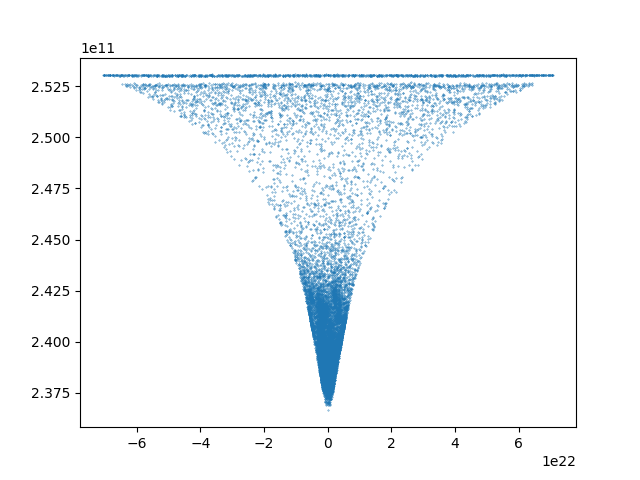

In [51]:
def sum_individual_contributions(mesh, origin, coordinates):
    '''Summing individual contributions of each source linearly'''
    
    #Initialising the sum for the potentials to be 0, then add each contribution to it from each source
    potential_off_center = 0
    
    #Setting the distances to be from the origin so we have the same coordinates for all individual potential
    #and we can coherently add them together
    V, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted = rearrange_mesh_data(mesh, origin)
    
    #Assigning each coordinate from the array given as input
    coordinates_x = coordinates[:,0]
    coordinates_y = coordinates[:,1]
    coordinates_z = coordinates[:,2]
    
    #Summing over each source
    for i in range(len(coordinates_x)):
    
        #Defining the potential with respect to a displaced source, but with the usual coordinates
        potential_off_center += (sqrt(G*source_mass*a0)*1/2*np.log((x_coords-coordinates_x[i])**2+
                    (y_coords-coordinates_y[i])**2 + (z_coords-coordinates_z[i])**2))
    
    return potential_off_center

potential_individual_sum = sum_individual_contributions(mesh, origin, random_coordinates)

type(potential_individual_sum)

plt.figure()

# plt.scatter(x_coords, potential_individual_sum, s = 0.1)
plt.scatter(x_coords, potential, s=0.1)


<IPython.core.display.Javascript object>


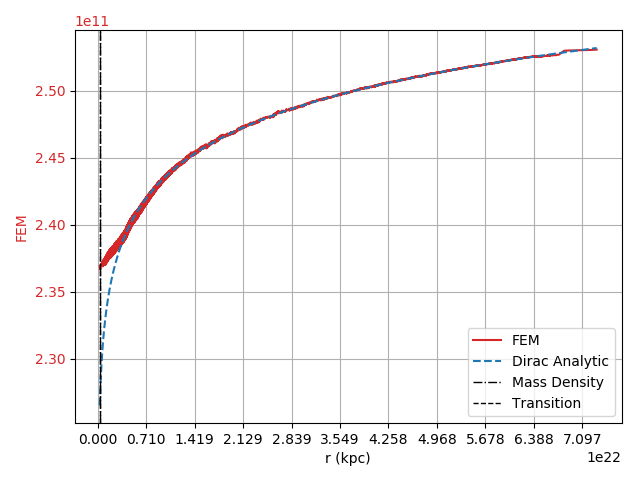

In [52]:
radial_plots_start = time.time()

#Defining analytic functions to check if the result is correct
#2nd argument of Heaviside is its value where the Heaviside goes from 0 to 1
potential_sphere_analytic = (np.heaviside(r_sorted - radius_tot, 0.5)*sqrt(G*mgb*a0)*np.log(r_sorted) +
(np.heaviside(radius_tot - r_sorted, 0.5))*(4/3*sqrt(pi/3*a0*G*mgb/volume_out)*np.power(r_sorted,3/2)+
sqrt(G*mgb*a0)*ln(radius_tot) - 4/3*sqrt(pi/3*a0*G*mgb/volume_out)*radius_tot**(3/2)))

#Analytic potential on the inside of a sphere
potential_inside_analytic = (4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*np.power(r_sorted,3/2)+
sqrt(G*mgb*a0)*ln(radius_tot) - 4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*radius_tot**(3/2))

#Analytic potential for a Dirac Delta
potential_dirac_analytic = sqrt(G*mgb*a0)*np.log(r_sorted)

#Analytic potential for multiple sources (scales with sqrt(#masses))
potential_multiple_dirac_analytic = sqrt(G*mgb*a0/source_number)*np.log(r_sorted)

#Analytic potentials for isothermal distribution
potential_isothermal_analytic = 2/3*sqrt(G*mgb*a0/6)*np.log(1 + np.power(r_sorted, 3/2)/p**(3/2))

#Plotting radial FEM solution and analytic solution on the same plot. We use subplots so'
#we can put multiple axes on the same plot and plot different scales
fig, potential1 = plt.subplots()

color = 'tab:red'
potential1.set_ylabel('FEM', color=color)

potential1.plot(r_sorted, potential_sorted, label = 'FEM', color=color, linestyle='-')

#Plotting the GEA potential as well
# potential1.plot(r_sorted, potential_GEA_sorted, label = 'FEM_GEA', color='tab:green', linestyle='--', linewidth=0.5)

potential1.tick_params(axis='y', labelcolor=color)

#UNCOMMENT TO HAVE SEPARATE AXES TO COMPARE SHAPES
# potential2 = potential1.twinx()
color = 'tab:blue'
# potential2.set_ylabel('Analytic', color=color)
plt.plot(r_sorted, potential_multiple_dirac_analytic, label = 'Dirac Analytic', linestyle = '--', )
# potential2.plot(r_sorted, potential_sphere_analytic, label = 'Dirac Analytic', linestyle = '--', color=color)

#It is possible to use Latex directly in the labels by enclosing expressions in $$
# plt.ylabel('$\phi$')

plot_annotations()

#Formatting plot using the function I made
plot_format(1,1)

## Finding the error in the potential, radially

<IPython.core.display.Javascript object>


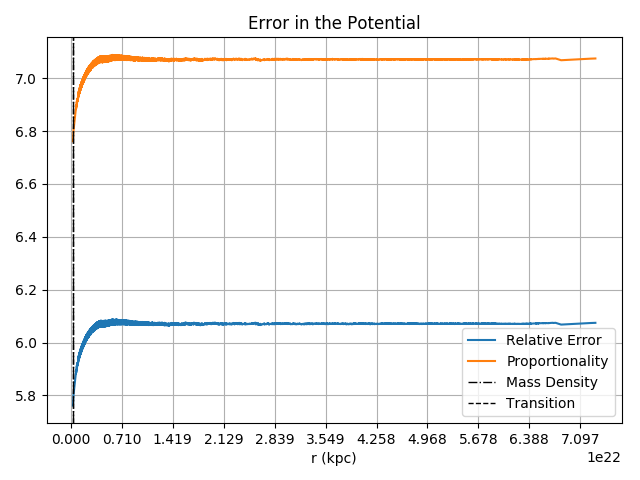

In [53]:
#for spherically symmetric mass distributions we have the anlytic solution, so we can compute
#the error
potential_error = np.abs((potential_sorted - potential_dirac_analytic)/potential_sorted)
potential_proportionality = potential_dirac_analytic/potential_sorted

#plotting the error against the radius
plt.figure()
plt.plot(r_sorted,potential_error, label = 'Relative Error')
plt.plot(r_sorted,potential_proportionality, label = 'Proportionality')
plt.title('Error in the Potential')
plot_annotations()
plot_format(1,1)

# Looking at the value of the potential along a specific axis. Useful when dealing with a non-radially symmetric distribution

<IPython.core.display.Javascript object>


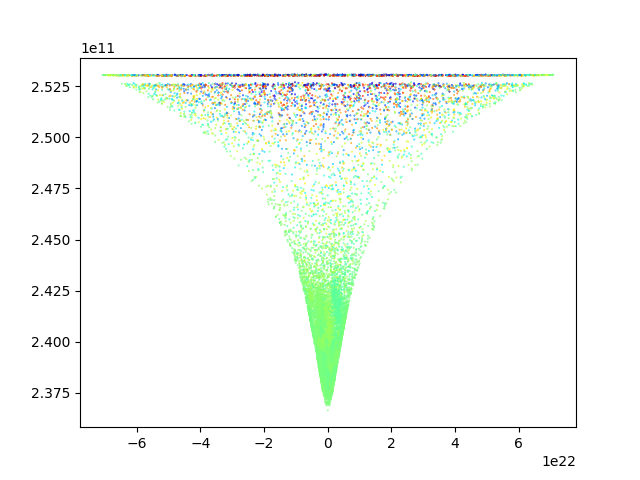

In [54]:
plt.figure()

plt.scatter(x_coords, potential, marker = '.', s = 0.5, c = y_coords/y_coords.max(), cmap = 'jet')


## Next, the acceleration

<IPython.core.display.Javascript object>


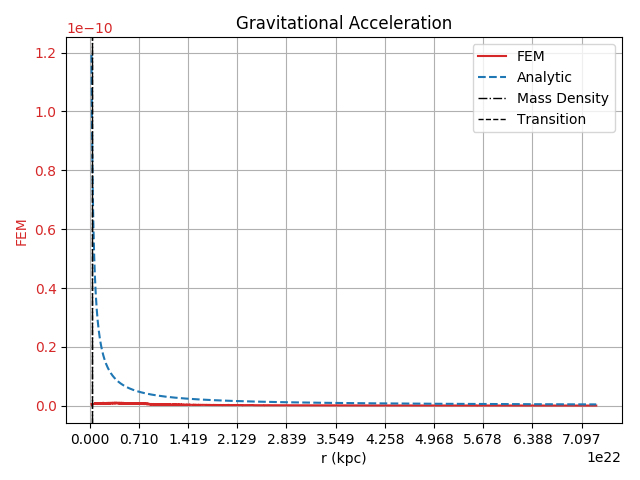

In [55]:
#Defining analytic functions to check if the result is correct
#2nd argument of Heaviside is its value where the Heaviside goes from 0 to 1
acceleration_sphere_analytic = (np.heaviside(r_sorted - radius_tot, 0.5)*sqrt(G*mgb*a0)*1/r_sorted+
(np.heaviside(radius_tot-r_sorted, 0.5))*4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*np.sqrt(r_sorted))

acceleration_dirac_analytic = sqrt(G*mgb*a0)*1/r_sorted

fig, acceleration1 = plt.subplots()

color = 'tab:red'
acceleration1.set_ylabel('FEM', color=color)

acceleration1.tick_params(axis='y', labelcolor=color)

#Plotting radial FEM solution and analytic solution on the same plot
acceleration1.plot(r_sorted, acceleration_magnitude_sorted, label = 'FEM', color = color)

#UNCOMMENT TO HAVE SEPARATE Y AXES
# acceleration2 = acceleration1.twinx()
color = 'tab:blue'
# acceleration2.set_ylabel('Analytic', color=color)

plt.plot(r_sorted, acceleration_sphere_analytic, label = 'Analytic', linestyle = '--', color = color)
plt.title('Gravitational Acceleration')

plot_annotations()

#Formatting plot using the function I made
plot_format(1,1)

## Finding the error in the acceleration

<IPython.core.display.Javascript object>


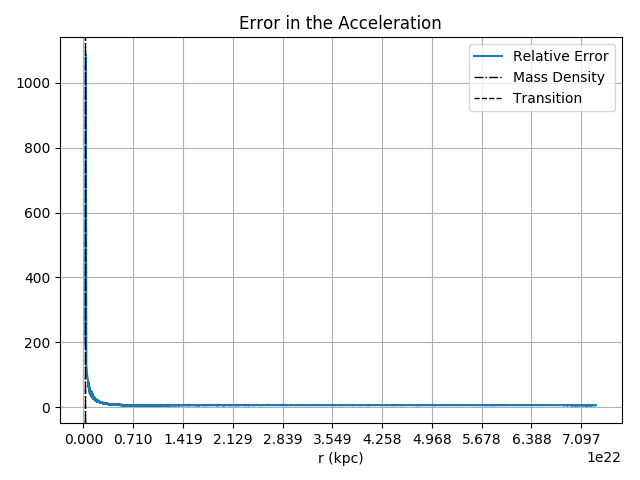

In [56]:
#for spherically symmetric mass distributions we have the anlytic solution, so we can compute
#the error
acceleration_error = np.abs((acceleration_magnitude_sorted - acceleration_dirac_analytic)/acceleration_magnitude_sorted)

#plotting the error against the radius
plt.figure()
plt.plot(r_sorted,acceleration_error, label = 'Relative Error')
plt.title('Error in the Acceleration')
plot_annotations()
plot_format(1,1)

## Plotting the source to check its value

<IPython.core.display.Javascript object>


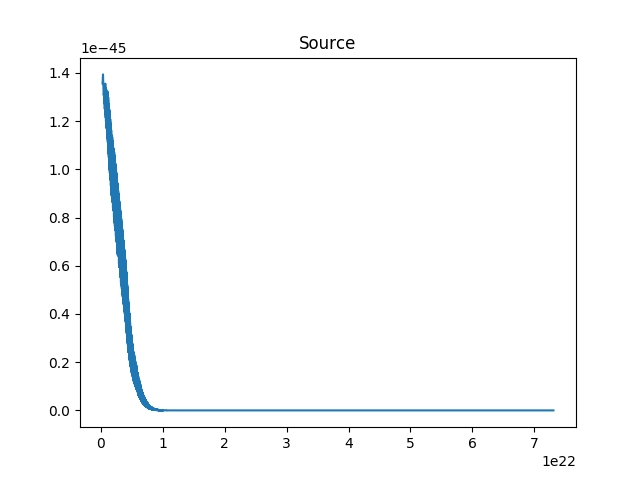

Text(0.5, 1.0, 'Source')

In [57]:
plt.figure()
plt.plot(r_sorted, source_sorted)
plt.title('Source')

## Histogram to look at the radial vertex distribution
### First, defining the function to do this

In [58]:
def radial_dist_hist(mesh, density, bins):
    
    #Having independent y axes so we don't need to adjust the function to compare the scaling 
    fig, histo = plt.subplots()
    color = 'tab:blue'
    histo.set_ylabel('radial distance density', color=color)
    histo.tick_params(axis='y', labelcolor=color)
    
    #Looking at how the points are distributed radially. If they are uniform, their density
    #should increase with r^2 due to sphere surface
    #plotting histogram of point density radially
    to_hist = histo.hist(r_coords, density=density, bins=bins, label = 'distribution', color = color)
    
    #Adding the value of each bin on top of the bin
    for i in range(bins):
        plt.text(to_hist[1][i],to_hist[0][i],str(int(to_hist[0][i])))
    
    #Putting the grid with the histogram values as those are the interesting quantities
    plt.grid()
    
    #Second y axis
    quadratic = histo.twinx()
    color = 'tab:orange'
    quadratic.set_ylabel('Quadratic', color=color)
    quadratic.tick_params(axis='density', labelcolor=color)
    
    #plotting a cubic relation, scaled by the max element^3 to be of order unity
    quadratic.plot(r_sorted, np.power(r_sorted,2), label = 'quadratic', color = color)
    
    #Forcing the lower limit in both plots to 0 so there's no offset
    plt.ylim(bottom=0)
    
    plt.tight_layout()
    plt.legend()

### Applying the function to the generated mesh

<IPython.core.display.Javascript object>


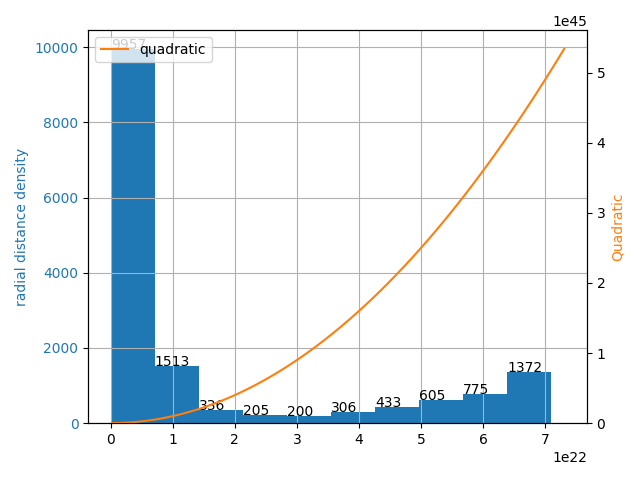

In [59]:
radial_dist_hist(mesh, False, 10)

radial_plots_end = time.time()
radial_plots_time = run_time(radial_plots_start - radial_plots_end, 'Radial Plots')
# section_times.append(radial_plots_time)

## Defining function to interpolate solution over a finer mesh, over which we can then plot and get nicer looking graphs, albeit less precise due to errors in interpolation.

In [60]:
# #Resolution of the plane mesh
# plane_resolution = 61

# #Giving the size of the bigger square mesh
# plane_mesh_side = domain_size

# #Defining points for the corners of the mesh we need. Point locations at half the side length
# mesh_left_corner = Point(-plane_mesh_side/2, -plane_mesh_side/2)
# mesh_right_corner = Point(plane_mesh_side/2, plane_mesh_side/2)

# #Defining the mesh through a dolfin function instead of a mshr function
# plane_mesh = RectangleMesh(mesh_left_corner,mesh_right_corner,plane_resolution,plane_resolution)

# #Initialising a Mesh object (so correct dolfin mesh object we can use Mesh Functions on)
# #for the mesh made with Dolfin
# plane_mesh = Mesh(plane_mesh)

# plt.figure()
# plot(plane_mesh)

## For non spherically symmetric meshes, and for visual clarity, taking a slice of the mesh and plotting it in 2D

## First, a 3D view of the mesh vertices

In [61]:
def plot_mesh(figure, vertex_fraction, color, show_mesh = False, alpha = 0.3):
    '''
    Plotting the first vertex_number/vertex_fraction points of the mesh, based on radial
    distance. Need to input a figure name of format figure = plt.figure() for the subplot
    to work. Through this, we can embed this plot into other plots. Adding optional mesh and
    alpha inputs.
    '''
    
    #Getting the number of vertices required as an intege of the fraction given
    how_many = int(vertex_number/vertex_fraction)
    
    #projection='3d' needed to specify a 3D scatter plot
    mesh_scatter = figure.add_subplot(111, projection='3d')
    
    #plotting the total/vertex_fraction closest vertices to the origin
    #s gives the size of the dots, multiplying it by vertex_fraction so when we have less dots
    #we can make them more visible
    (mesh_scatter.scatter(x_sorted[0:how_many], y_sorted[0:how_many], z_sorted[0:how_many],
                         marker = '.', s=1*vertex_fraction, c = color))
    
    #Adding optional to show the mesh at the same time
    if show_mesh:
        plot(mesh, alpha = alpha, color = 'w')
    else:
        pass

<IPython.core.display.Javascript object>


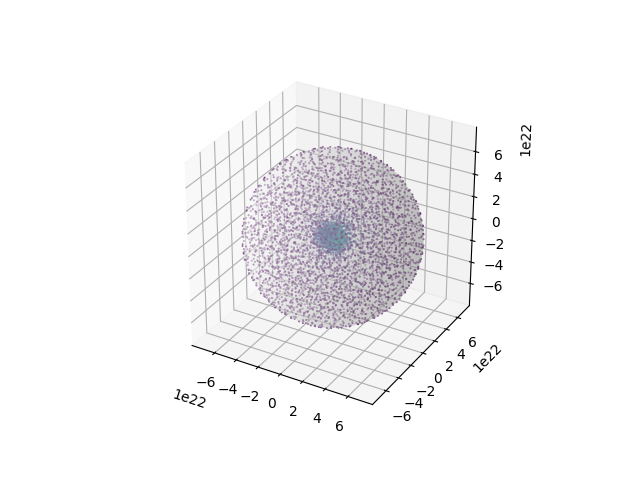

In [62]:
plots_3D_start = time.time()

#Have to first declare a figure and use its name as an input to the function
#This way the plot can be plotted alongside other plots on the same grid
whole_mesh = plt.figure()

#Plotting the points 
plot_mesh(whole_mesh, 1, acceleration_magnitude_sorted, show_mesh=True, alpha = 0.3)

## Obtaining a slice of mesh points close to the xy plane

In [63]:
def slice_mesh(amount, mesh, height = 0, portion = True, values = True, *args):
    '''Selecting only points of the mesh that are close to the xy plane. First, sorting points
    according to their z coordinate, then selecting either amount # of them or a portion of the
    total, dpeending on 'portion'. Optionally output a function args[0] at those points
    '''
    
    #Getting abs(z), distance from xy plane, and getting the index that sorts this new array
    xy_plane_distance = np.abs(z_coords - height)
    
    #index of points sorted by distance from xy plane (absolute value of z coordinate)
    z_sorting_index = xy_plane_distance.argsort()
    
    #x,y,z coordinates of point sorted by distance from xy plane
    z_xy_plane = z_coords[z_sorting_index]
    x_xy_plane = x_coords[z_sorting_index]
    y_xy_plane = y_coords[z_sorting_index]
    
    #If using the portion option, we take all points below a cutoff given by domain_size/amount
    if portion == True:
        
        #counting number of points with xy_plane distance > domain_size/amount
        amount = np.count_nonzero(xy_plane_distance < int(domain_size/amount))
    
    #If not using the portion option, the slice has num_vertices/amount total # points
    else:
        
        amount = int(mesh.num_vertices()/amount)
                
    #The slice has amount # points
    x_xy_plane = x_xy_plane[0:amount]
    y_xy_plane = y_xy_plane[0:amount]
    z_xy_plane = z_xy_plane[0:amount]

    if values == True:
        function_xy_plane = args[0][z_sorting_index]
        function_xy_plane = function_xy_plane[0:amount]
        
        return x_xy_plane, y_xy_plane, z_xy_plane, function_xy_plane, amount
    
    else:
        return x_xy_plane, y_xy_plane, z_xy_plane, amount

In [64]:
def plot_mesh_slice(amount, figure, source_coordinates, height = 0, portion = True, show_mesh = True, cross_section = False, alpha = 0.3, show_source = True):
    '''
    Plotting a slice of points on the mesh close to the xy axis, so for small z.
    Need to create a figure before calling the function. Optional showing mesh on top
    of scatter, True by default, and transparency of mesh set by default to 0.3
    '''
    
    #Calling the slice_mesh function to slice the mesh before plotting
    x_xy_plane, y_xy_plane, z_xy_plane, amount = (slice_mesh(amount, mesh, height = height,
                                                             portion = portion, values = False))
    
    #projection='3d' needed to specify a 3D scatter plot
    mesh_xy_axis = figure.add_subplot(111, projection='3d')
    
    #plotting the total/vertex_fraction closest vertices to the origin
    #s gives the size of the dots, multiplying it by vertex_fraction so when we have less dots
    #we can make them more visible
    (mesh_xy_axis.scatter(x_xy_plane, y_xy_plane, z_xy_plane,
                         marker = '.', s=vertex_number/amount, c = z_xy_plane))
    
    #Plotting the source(s) on top of the mesh points, to check if we refine mesh correctly
    if show_source == True:
        
        (mesh_xy_axis.scatter(random_coordinates[:,0],random_coordinates[:,1],
        random_coordinates[:,2], marker = 'o', s=vertex_number/amount*5, c = 'r', label='Source'))
            
    
    #Projecting each point on the xy plane, at z=0 (zs=0)
    mesh_xy_axis.plot(x_xy_plane, y_xy_plane, 'b+', zdir='z', zs=height, label = 'xy-plane projection')
    
    mesh_xy_axis.legend()
    
    #Adding optional to show the mesh at the same time
    if show_mesh:
        plot(mesh, alpha = alpha, color = 'w')
    else:
        pass
    
    #Option to plot the cross section, color coded by distance from xy plane
    if cross_section:
        plt.figure()
        plt.scatter(x_xy_plane, y_xy_plane, c = z_xy_plane, marker = '+')
        
        if show_source:
            (plt.scatter(random_coordinates[:,0],random_coordinates[:,1], marker = 'o',
            color = 'r', s=vertex_number/amount*5))
        
    else:
        pass

<IPython.core.display.Javascript object>


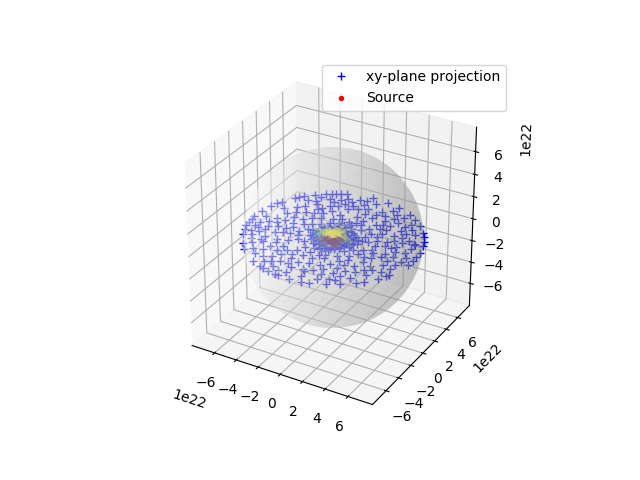

<IPython.core.display.Javascript object>


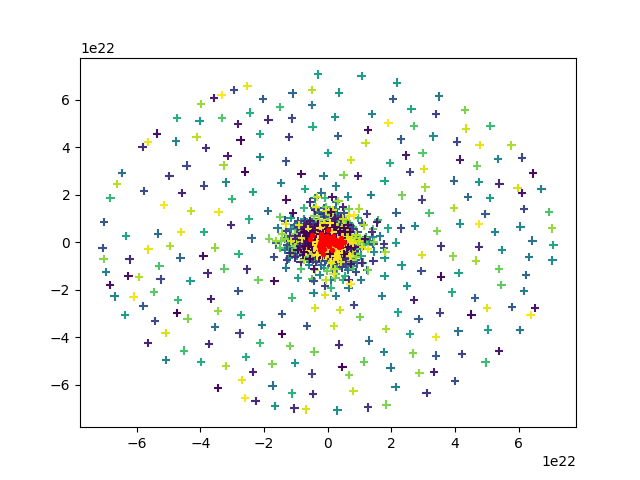

In [65]:
mesh_plane = plt.figure()
plot_mesh_slice(20, mesh_plane, random_coordinates, height = center_of_mass_z, portion = True, cross_section=True, show_source=True)

## Defining a function to plot a trisurf graph of a slice of the domain, here the xy axis

In [66]:
def trisurf_function_slice(figure, function, amount, height, slices = 50, high_low = 'low', project = True):
    '''Plot a trisurf along a plane (currently only the xy-plane) of a given function. The slice
    of points defining the xy plane is obtained from the slice_mesh function. Then, project
    the triangulated surface onto each axis if optional arg project = True. high_low determines
    whether to project the xy plane contour above or below surface
    '''
    
    #Obtaining the x,y coordinates and functions to plot from slice_mesh
    x_xy_plane, y_xy_plane, z_xy_plane, function_xy_plane, amount = (slice_mesh(amount,
                                            mesh, height, True, True, function))
    
    #Adding a subplot to the figure input
    plane_trisurf = figure.add_subplot(111, projection='3d')
    
    #Plotting the trisurf (triangulated surface) on the plane
    plane_trisurf.plot_trisurf(x_xy_plane, y_xy_plane, function_xy_plane, cmap = 'jet')
    
    #Setting the x and y limits to leave some space for the contours to be clearer
    x_bottom, x_top = plt.xlim(-domain_size*1.2, domain_size*1.2) 
    y_bottom, y_top = plt.ylim(-domain_size*1.2, domain_size*1.2) 
    
    #Setting the z limit conditionally, based on the function being increasing or decreasing
    if high_low == 'high':
        z_limit = function.max()
    
    else:
        z_limit = function.min()
    
    #If project = True, project contours on each axis
    if project:
    
        #Projecting contours of the surface in each cartesian direction using zdir and offset
        #for direction and offset from the axes origins respectively
        plane_trisurf.tricontourf(x_xy_plane, y_xy_plane, function_xy_plane, slices, zdir='z', offset=z_limit, cmap = 'jet')
        plane_trisurf.tricontourf(x_xy_plane, y_xy_plane, function_xy_plane, slices, zdir='x', offset=y_bottom, cmap = 'jet')
        plane_trisurf.tricontourf(x_xy_plane, y_xy_plane, function_xy_plane, slices, zdir='y', offset=x_top, cmap = 'jet')

<IPython.core.display.Javascript object>


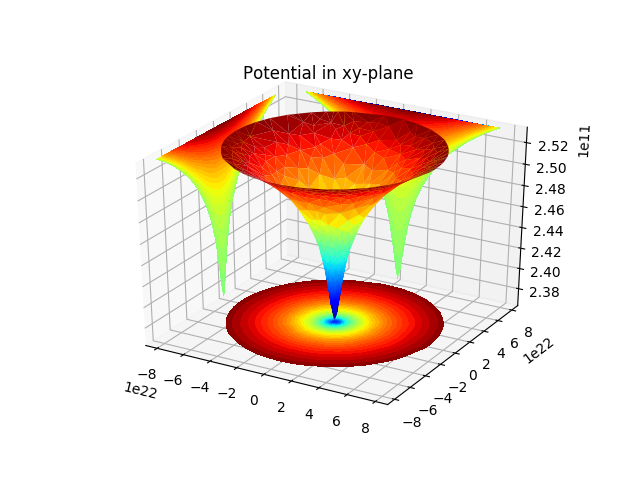

Text(0.5, 0.92, 'Potential in xy-plane')

In [67]:
trisurf_potential = plt.figure()
trisurf_function_slice(trisurf_potential, potential, 20, center_of_mass_z)
plt.title('Potential in xy-plane')

<IPython.core.display.Javascript object>


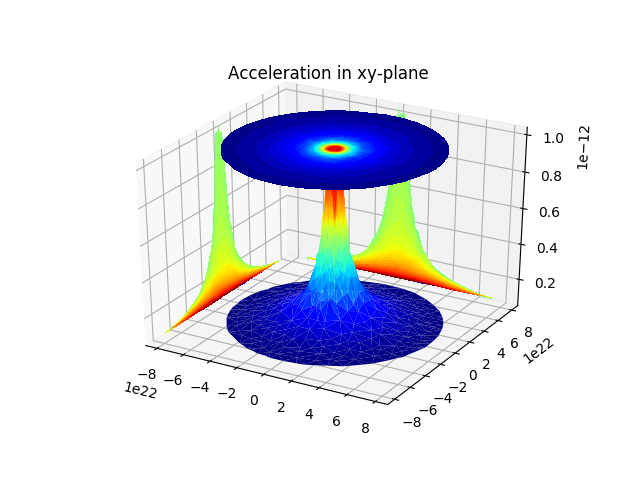

Text(0.5, 0.92, 'Acceleration in xy-plane')

In [68]:
trisurf_acceleration = plt.figure()
trisurf_function_slice(trisurf_acceleration, acceleration_magnitude, 20, center_of_mass_z, high_low = 'high')
plt.title('Acceleration in xy-plane')

In [69]:
# trisurf_source = plt.figure()
# trisurf_function_slice(trisurf_source, source, 20, center_of_mass_z, high_low = 'high')
# plt.title('Source in xy-plane')

## Plotting contour lines of the potential, so we can do that for different values of z and see the whole domain.

In [70]:
def tricontour_function_slice(figure, function, amount, levels, height):
    '''Plot a trisurf along a plane (currently only the xy-plane) of a given function. The slice
    of points defining the xy plane is obtained from the slice_mesh function
    '''
    
    #Obtaining the x,y coordinates and functions to plot from slice_mesh
    x_xy_plane, y_xy_plane, z_xy_plane, function_xy_plane, amount = (slice_mesh(amount,
                                            mesh, height, True, True, function))
    
    #Adding a subplot to the figure input. Not adding the projection = 3d option so we have it 
    #all in one plane and can plot multiple for e.g. different values of z
    plane_tricontour = figure.add_subplot(111)
    
    #Defining the levels of the contour to be between the max and min value of the function
    #in 'levels' homogeneous steps
    contour_levels = np.linspace(function.min(), function.max(), levels)
    
    #Plotting the contour
    plane_tricontour.tricontour(x_xy_plane, y_xy_plane, function_xy_plane, contour_levels, cmap = 'jet')

<IPython.core.display.Javascript object>


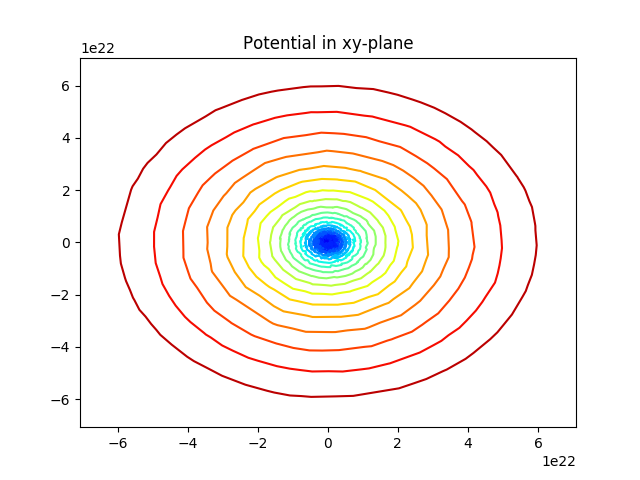

Text(0.5, 1.0, 'Potential in xy-plane')

In [71]:
tricontour_potential = plt.figure()
tricontour_function_slice(tricontour_potential, potential, 20, 20, center_of_mass_z)
plt.title('Potential in xy-plane')

<IPython.core.display.Javascript object>


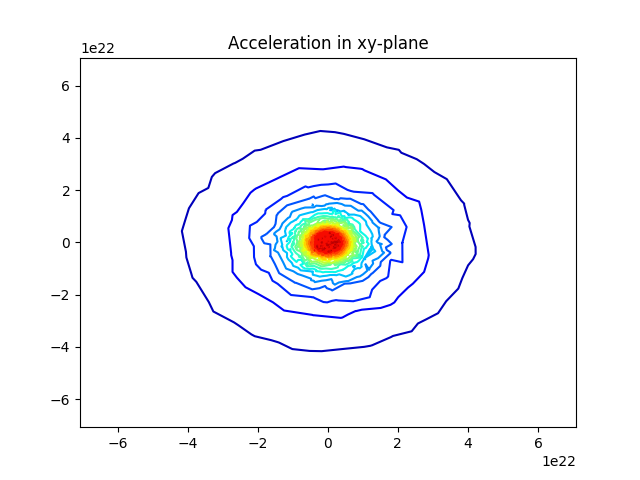

Text(0.5, 1.0, 'Acceleration in xy-plane')

In [72]:
trisurf_acceleration = plt.figure()
tricontour_function_slice(trisurf_acceleration, acceleration_magnitude, 20, 20, center_of_mass_z)
plt.title('Acceleration in xy-plane')

<IPython.core.display.Javascript object>


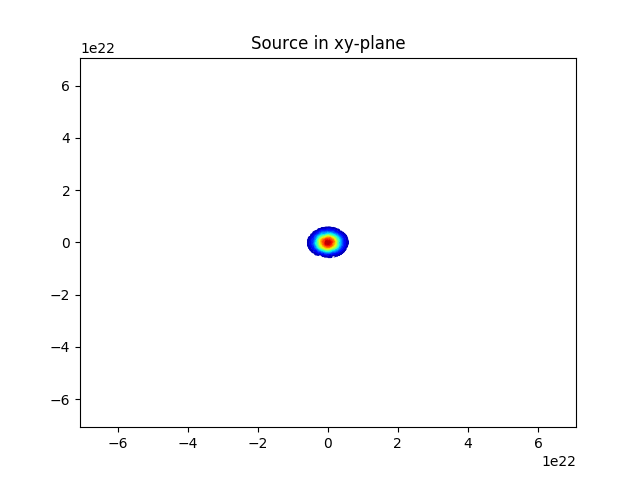

Text(0.5, 1.0, 'Source in xy-plane')

In [73]:
trisurf_source = plt.figure()
tricontour_function_slice(trisurf_source, source, 20, 20, center_of_mass_z)
plt.title('Source in xy-plane')

## Making a function to plot slices and view them in 3D
### The 2 cells below this on contain the call to the function

In [74]:
def contour_3D_slices(figure, function, amount, height, slices = 50, high_low = 'low'):
    
    #Adding a subplot to the figure input
    plane_trisurf = figure.add_subplot(111, projection='3d')

    #Setting the x and y limits to leave some space for the contours to be clearer
    x_bottom, x_top = plt.xlim(-domain_size*1.2, domain_size*1.2) 
    y_bottom, y_top = plt.ylim(-domain_size*1.2, domain_size*1.2) 
#     z_bottom, z_top = Axes3D.zlim(-domain_size*1.2, domain_size*1.2) 
    
    #Setting the z limit conditionally, based on the function being increasing or decreasing
    if high_low == 'high':
        z_limit = function.max()
    
    else:
        z_limit = function.min()
    
    #Obtaining a range of n values for both the function and the domain (from min to max)
    function_to_loop = np.linspace(function.min(), function.max(), 11)
    height_to_loop = np.linspace(-domain_size*0.9, domain_size*0.9, 11)
    
    #Stacking the two ranges together so we can loop over them, and transpose so that each
    #element of the array is a pair of corresponding function value-domain location
    total_to_loop = np.vstack((function_to_loop, height_to_loop))
    total_to_loop = np.transpose(total_to_loop)
    
    #Looping over the function-domain slice pairs
    for elevations in total_to_loop:
        
        #IMPORTANT! For this loop to work, we need to have the same #function points for each
        #slice. So we need to set the portion option from slice_mesh to False, so it takes
        #the same #points every time, and not whatever number is within the given range
        #Obtaining the x,y coordinates and functions to plot from slice_mesh
        x_xy_plane, y_xy_plane, z_xy_plane, function_xy_plane, amount = (slice_mesh(amount,
                                                mesh, elevations[1], False, True, function))

        #Projecting contours of the surface in each cartesian direction using zdir and offset
        #for direction and offset from the axes origins respectively
        plane_trisurf.tricontourf(x_xy_plane, y_xy_plane, function_xy_plane, slices, zdir='z', offset=elevations[0],cmap = 'jet')
    #     plane_trisurf.tricontourf(x_xy_plane, y_xy_plane, function_xy_plane, slices, zdir='x', offset=y_bottom, cmap = 'jet')
    #     plane_trisurf.tricontourf(x_xy_plane, y_xy_plane, function_xy_plane, slices, zdir='y', offset=x_top, cmap = 'jet')

In [75]:
#IMPORTANT: Right now, using a predefined amount of contours for each level, but this means
#that the colors ar enot consistent between different levels! So want to change it that instead
#of a numebr of contours, we have contours at specific values! That way the plot makes sense,
#and it will also look like a sphere since the max potential will be at the boundary, which 
#becomes smaller for each level.

# potential_slices = plt.figure()

# contour_3D_slices(potential_slices, potential, 100, 0)

In [76]:
# acceleration_slices = plt.figure()

# contour_3D_slices(acceleration_slices, acceleration_magnitude, 100, 0)

In [77]:
# source_slices = plt.figure()

# contour_3D_slices(source_slices, source, 100, 0)

## Looking at a quiver plot of the acceleration (useful when having multiple masses)

<IPython.core.display.Javascript object>


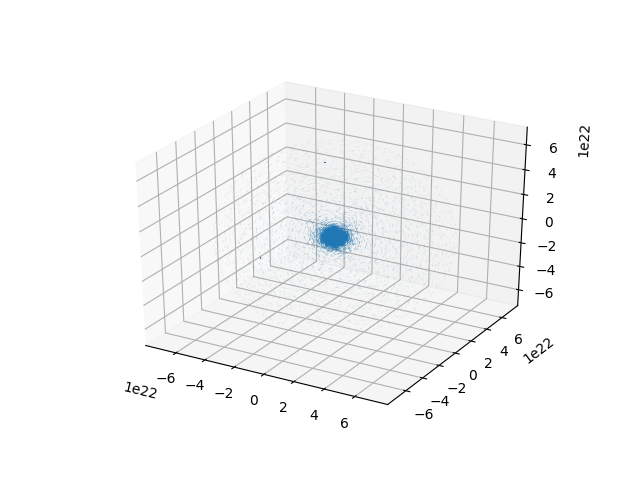

In [78]:
figure = plt.figure()

quivers = figure.add_subplot(111, projection='3d')

quivers.quiver(x_coords, y_coords, z_coords, acceleration_x, acceleration_y, acceleration_z, length = 10**6*10**7*kp, normalize = False)


In [79]:
plots_3D_end = time.time()
plots_3D_time = run_time(plots_3D_end - plots_3D_start, '3D Plots')
section_times.append(plots_3D_time)

# Trying to construct mesh through MeshEditor

In [80]:
# domain_trial = mshr.Sphere(origin, domain_size)
# mesh_trial = mshr.generate_mesh(domain_trial, 21)
# # mesh_trial

In [81]:
# #Initialising a MeshEditor object
# mesh_edit = MeshEditor()

# #Opening an existing mesh with MeshEditor. Need to specify the cell name (string, 'tetrahedron'),
# #the topological dimension (not sure what it is!) and geometrical dimensions (3)
# mesh_edit.open(mesh_trial,mesh_trial.cell_name(), 3,3)

# #Generating three coordinate vectors to make a grid
# x_grid = np.linspace(0,1,10)
# y_grid = x_grid.copy()
# z_grid = x_grid.copy()

# #Making a 3D grid and assigning the grid values to three variables
# X, Y, Z = np.meshgrid(x_grid, y_grid, z_grid)

# #Flattening each coordinate array (ravel), then stacking them vertically, so that we now 
# #have an nd.array with 3 rows (one per coordinate, XYZ), and n columns, one per point
# #Stacked in this order to get the correct order in the array for checking correctness
# positions = np.vstack([Y.ravel(), X.ravel(), Z.ravel()])

# #Transposing the 3*n matrix into an n*3 matrix so we can use a list comprehension to assign 
# #point, as now positions[0] will give the three coordinate values instead of all n x-values!
# positions = positions.transpose()

# #List comprehension to make a list of points with coordinates from 'positions'
# grid_points = [Point(coordinates) for coordinates in positions]

# #Getting the amount of grid points
# grid_vertex_number = len(grid_points)

# #Declaring the amount of vertices in the mesh. Have to do this before adding any vertex!
# #This limits the available vertex indices, so if you try to add more than you declared, you
# #get an error!
# mesh_edit.init_vertices(grid_vertex_number)

# #Adding the vertices in grid_points to the mesh
# [mesh_edit.add_vertex(i,point) for i, point in enumerate(grid_points)]

# mesh_edit.close()

# mesh_trial.num_vertices()
# # mesh_trial.coordinates()

# #IMPORTANT: The problem with the MeshEditor is that it is not sufficient to define the vertices
# #One also has to define the cells! Need to look for a function that does that automatically
# #possibly with a Delaunay triangulation!

In [82]:
# u_plot = interpolate(u, V_plot)
# plt.figure()
# plot(u_plot)

## Plotting the times taken by each section to profile the code

<IPython.core.display.Javascript object>


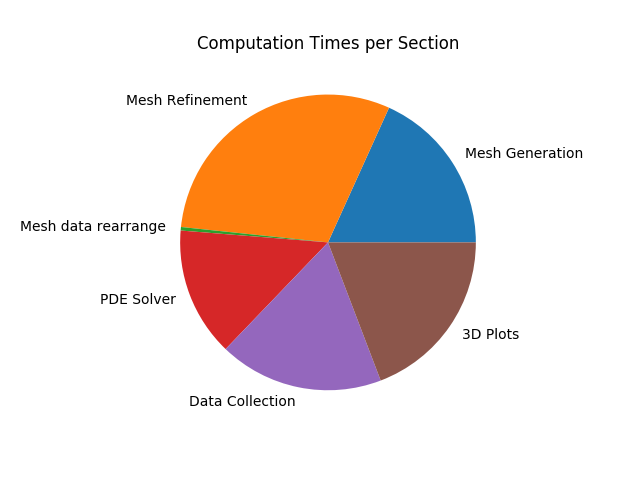

Text(0.5, 1.0, 'Computation Times per Section')

In [83]:
plt.figure()
pie_name = [section.name for section in section_times]
pie_time = np.zeros((len(section_times),1))

#can't use a list comprehension as for pie_name to make a numpy array, cause it makes
#a list instead! and for numbers it's always best to work with numpy 
for i, section in enumerate(section_times):
    pie_time[i] = section.time
    
#percentage of time taken, to display on the pie chart
pie_time_percent = [pie_time/(pie_time.sum()*100)]

#plotting the pie chart
plt.pie(pie_time, labels = pie_name)
# plt.legend()
plt.title('Computation Times per Section')

In [84]:
print('Overall time taken: {} s \n'.format(time.time() - starting_time))

Overall time taken: 26.4919912815094 s 



In [85]:
#Uncomment to close all figures so it doesnt take up all the memory
# plt.close('all')

## Other instance of main solver to either compare solutions or explore parameter space etc.

<IPython.core.display.Javascript object>


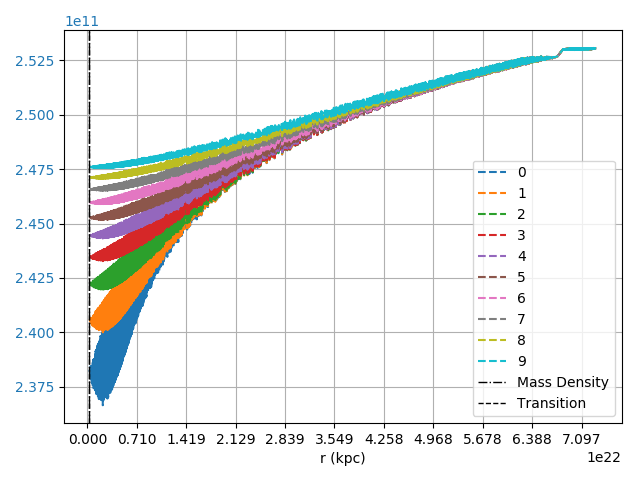

On the 0th iteration
Starting PDE Solver...

PDE solved in 1.9798572063446045

On the 1th iteration
Starting PDE Solver...

PDE solved in 2.185554027557373

On the 2th iteration
Starting PDE Solver...

PDE solved in 2.376866579055786

On the 3th iteration
Starting PDE Solver...

PDE solved in 2.384676456451416

On the 4th iteration
Starting PDE Solver...

PDE solved in 2.584318161010742

On the 5th iteration
Starting PDE Solver...

PDE solved in 2.6018009185791016

On the 6th iteration
Starting PDE Solver...

PDE solved in 2.5973024368286133

On the 7th iteration
Starting PDE Solver...

PDE solved in 2.8038461208343506

On the 8th iteration
Starting PDE Solver...

PDE solved in 2.7973926067352295

On the 9th iteration
Starting PDE Solver...

PDE solved in 2.79610013961792



In [91]:
fig, potential1 = plt.subplots()

for i in range(10):
    
    print(f'On the {i}th iteration')
    
    stand_dev = domain_size/(30)*(i+1)
    
    #String to create a different label for each curve
    label_string = f'{i}'
    
    ## starting time of PDE solver
    solver_start = time.time()
    print('Starting PDE Solver...\n')

    #defining the x,y,z coordinates from the coordinate array in sympy
    x, y, z = sym.symbols('x[0], x[1], x[2]')

    # #Defining the r unit vector in terms of cartesian coordinates
    r_unit_1 = Expression('x[0]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])', degree = 1)
    r_unit_2 = Expression('x[1]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])', degree = 1)
    r_unit_3 = Expression('x[2]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])', degree = 1)

    # Declaring the expression for the source
    f = (Expression(f_exponent_test,
    degree = 0, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,
    volume_out = volume_out, center_of_mass_x = center_of_mass_x,
    center_of_mass_y = center_of_mass_y, center_of_mass_z = center_of_mass_z,
    source_number = source_number, source_mass = source_mass, stand_dev = stand_dev))

    # #Expression for multiple sources
    # f = eval(f_string_to_execute)

    #Declaring the expression for the initial guess
    u = (Expression(u_displaced_cpp,
    degree = 0, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,
    volume_out = volume_out, center_of_mass_x = center_of_mass_x,
    center_of_mass_y = center_of_mass_y, center_of_mass_z = center_of_mass_z,
    source_number = source_number, source_mass = source_mass))

    #Declaring the expression for the boundary condition with displaced CM (center of mass)
    boundary_CM = (Expression(u_displaced_cpp,
    degree = 0, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,
    volume_out = volume_out, center_of_mass_x = center_of_mass_x,
    center_of_mass_y = center_of_mass_y, center_of_mass_z = center_of_mass_z,
    source_number = source_number, source_mass = source_mass))

    #Defining a function for the boundary. Since we only have one BC for the whole boundary, we
    #can make a simple function that returns true for each value on the boundary
    #the on_boundary built-in function takes each point in domain and returns true if on boundary
    def boundary(x, on_boundary):
        return on_boundary

    #Declaring the boundary condition. It takes three arguments: function space, value of BC, 
    #section of the boundary (in our case the whole boundary).
    bc = DirichletBC(V, boundary_CM, boundary)

    #Defining the variational problem
    #u is the solution. for linear problems, we'd have to define it as TrialFunction, but for 
    #non-linear we define it as Function directly
    u = interpolate(u, V)

    #Getting a new variable to store the solution form the GEA PDE
    u_GEA = u

    #defining the test function
    v = TestFunction(V)

    # #Weak form for GEA with spherical symmetry component. Multiplying the distribution by 6/beta as for GEA
    # #we use the acceleration scale M=6a_0, so a_0-> 6a_0 and we need to divide by beta
    # F_GEA = (inner(sqrt(2*inner(grad(u_GEA), grad(u_GEA)) - c_2*((u_GEA.dx(0)*r_unit_1)+
    #         (u_GEA.dx(1)*r_unit_2)+(u_GEA.dx(2)*r_unit_3))**2)* grad(u_GEA), grad(v))*dx + 6/beta*f*v*dx)

    # #Computing the solution for normal deep MOND
    # (solve(F_GEA == 0, u_GEA, bc, solver_parameters={"newton_solver":{"relative_tolerance":1e-6},
    #                                          "newton_solver":{"maximum_iterations":200}}))



    # #defining the weak form to be solved
    F = inner(sqrt(inner(grad(u), grad(u))) * grad(u), grad(v))*dx + f*v*dx

    # #Computing the solution for normal deep MOND
    (solve(F == 0, u, bc, solver_parameters={"newton_solver":{"relative_tolerance":1e-6},
                                             "newton_solver":{"maximum_iterations":200}}))

    solver_end = time.time()
    solver_time = run_time(solver_end - solver_start, 'PDE Solver')
    section_times.append(solver_time)

    print('PDE solved in {}\n'.format(solver_time.time))

#     Value for the potential of the GEA equation
    potential = u.compute_vertex_values()
    #Sorting the potential for the GEA
    potential_sorted = potential[sorting_index]

    #Plotting radial FEM solution and analytic solution on the same plot. We use subplots so'
    #we can put multiple axes on the same plot and plot different scales

#     color = 'tab:red'
#     potential1.set_ylabel('FEM', color=color)

    plt.plot(r_sorted, potential_sorted, label = label_string, linestyle='--')

    potential1.tick_params(axis='y', labelcolor=color)

    #UNCOMMENT TO HAVE SEPARATE AXES TO COMPARE SHAPES
    # potential2 = potential1.twinx()
#     color = 'tab:blue'
    # potential2.set_ylabel('Analytic', color=color)
#     plt.plot(r_sorted, potential_multiple_dirac_analytic, label = 'Dirac Analytic', linestyle = '--', )
    # potential2.plot(r_sorted, potential_sphere_analytic, label = 'Dirac Analytic', linestyle = '--', color=color)

#It is possible to use Latex directly in the labels by enclosing expressions in $$
# plt.ylabel('$\phi$')

plot_annotations()

#Formatting plot using the function I made
plot_format(1,1)

In [87]:
# #Value for the potential of the GEA equation
# potential_GEA = u_GEA.compute_vertex_values()
# #Sorting the potential for the GEA
# potential_GEA_sorted = potential_GEA[sorting_index]

In [88]:
# #Plotting radial FEM solution and analytic solution on the same plot. We use subplots so'
# #we can put multiple axes on the same plot and plot different scales
# fig, potential1 = plt.subplots()

# color = 'tab:red'
# potential1.set_ylabel('FEM', color=color)

# potential1.plot(r_sorted, potential_GEA_sorted, label = 'FEM_GEA', color=color, linestyle='-')
# potential1.plot(r_sorted, potential_sorted, label = 'FEM', color='tab:green', linestyle='-')

# #Plotting the GEA potential as well
# # potential1.plot(r_sorted, potential_GEA_sorted, label = 'FEM_GEA', color='tab:green', linestyle='--', linewidth=0.5)

# potential1.tick_params(axis='y', labelcolor=color)

# #UNCOMMENT TO HAVE SEPARATE AXES TO COMPARE SHAPES
# # potential2 = potential1.twinx()
# color = 'tab:blue'
# # potential2.set_ylabel('Analytic', color=color)
# plt.plot(r_sorted, potential_multiple_dirac_analytic, label = 'Dirac Analytic', linestyle = '--', )
# # potential2.plot(r_sorted, potential_sphere_analytic, label = 'Dirac Analytic', linestyle = '--', color=color)

# #It is possible to use Latex directly in the labels by enclosing expressions in $$
# # plt.ylabel('$\phi$')

# plot_annotations()

# #Formatting plot using the function I made
# plot_format(1,1)